# Кейс №3 
Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения

В качестве исходных данных были взяты результаты экспериментальных исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала. Установка электронно-лучевой сварки, на которой проводились исследования, предназначена для сварки электронным лучом в глубоком вакууме деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых и специальных сплавов. Существующая установка электронно-лучевой сварки обеспечивает повторяемость режимов в рамках возможностей реализованной системы управления. Работы по сварке выполнялись на образцах-имитаторах, соответствующих технологическому изделию. Для уменьшения вложения энергии при сварке:
1.	Снижалась величина сварочного тока (IW);
2.	Увеличивался ток фокусировки электронного пучка (IF);
3.	Увеличивалась скорость сварки (VW);
4.	Менялось расстояние от поверхности образцов до электронно-оптической системы (FP). 

По совокупности параметров технологических режимов обеспечивались минимально возможные размеры сварных швов: глубина шва (Depth) и ширина шва (Width).
В процессе выполнения работ была произведена электронно-лучевая сварка 18-ти единиц образцов. Результаты металлографического контроля по размерам сварного шва для каждого образца проводились в 4-х поперечных сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне 19,8 – 20 кВ. Набор полученных данных собраны в составе режимов сварки, размеров сварочных швов в поперечных сечениях всех образцов.

Датасет: `/data/ebw_data.csv`

**Требуется:** 

Провести прогнозирование глубины (Depth) и ширины (Width) сварного шва в зависимости от параметров технологического процесса (IW, IF, VW, FP).

Таким образом, задание будет решаться в три этапа:

1. Обзор данных;
2. Предобработка данных;
3. Написание и тестирование моделей, выявление лучшей модели.

# 1. Обзор данных

In [1]:
# Импортируем необходимы библиотеки

# библиотеки для работы с данными
import pandas as pd
import numpy as np

# библиотеки для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Считываем данные
df = pd.read_csv('../data/ebw_data.csv')
# смотрим перые 5 строчек
df.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [3]:
df.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [4]:
# Получаем общую информацию о таблице исходных данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Столбцы `IW, IF, VW, FP` являются нашими признаками (фичами), а столбцы `Depth, Width ` являются нашими целевыми переменными (таргетами).

В исходных данных 72 объекта. Пропусков в данных нет. Давайте посмотрим на тепловую карту модулей попарных корреляций фичей и таргетов.

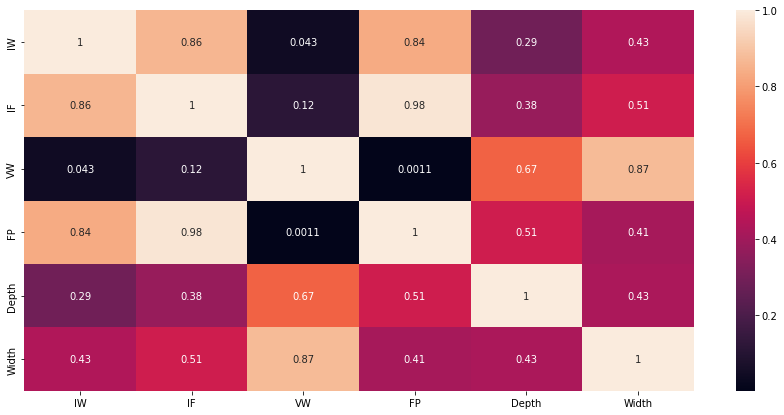

In [5]:
plt.figure(figsize=(15, 7))
sns.heatmap(data=abs(df.corr()), annot=True)
plt.show()

Нетрудно заметить, что все фичи коррелируют с таргетами. Признак `VW` сильнее всех коррелирует с таргетами, при этом корреляция с другими признаками очень близка к 0. Остальные фичи коррелируют друг с другом. Самая сильная связь наблюдается у признаков `FP и IF`, 0.98. Из этого можно сделать вывод, что при обучении линейных моделей мы должны использовать регулиризацию, чтобы избежать переобучения из-за мультиколлениарности признаков.

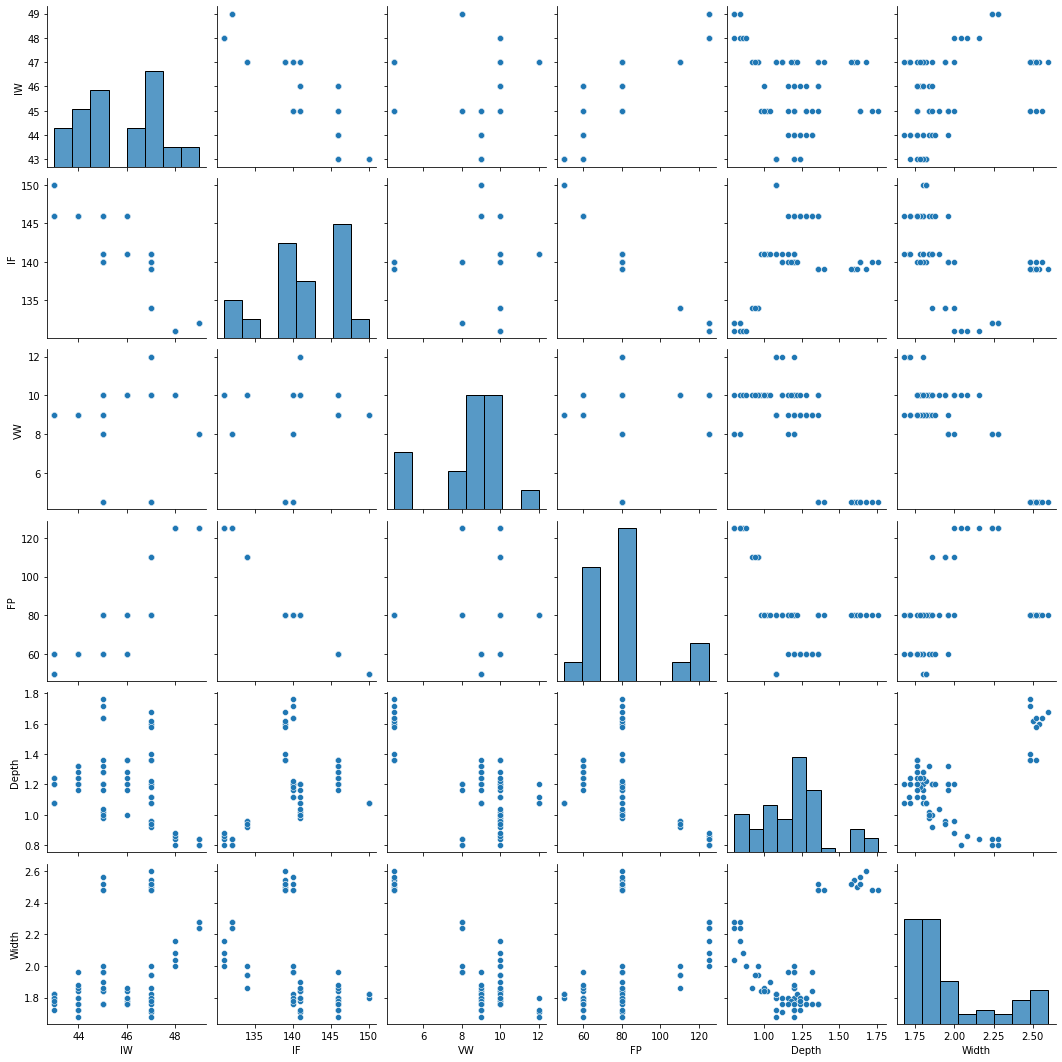

In [6]:
sns.pairplot(df)
plt.show()

Мы можем заметить, что большинство признаков находится друг над другом, стоит проверить данные на дубликаты.

In [7]:
print(df.iloc[:, :-2].duplicated().sum())

57


В датасете 57 дубликатов, в то время как общий размер датасета составляет 72 объекта. Можно сделать усреднение на таргетах при дубликатах. **Но** при использовании линейных моделей, случится тоже самое во время обучения. А при использовании нелинейных моделей(случайный лес) мы можем потерять информацию о нелинейных зависимостях, поэтому усреднение на дубликатах проводить не будем.

# 2. Предобработка данных

In [8]:
# стандартизиурем наш датасет
from sklearn.preprocessing import StandardScaler # импортируем метод для стандартизации датасета

In [9]:
scaler = StandardScaler()
scaler_data_with_features = scaler.fit_transform(df.iloc[:, :-2].values)
print(scaler_data_with_features[0]) # проверим, что всё получилось

[ 0.8        -0.45662965 -2.02221044  0.07808688]


In [10]:
# Подготовим данные для обучения, разделив Depth и Width
data_with_depth, data_with_width = np.array(df.iloc[:, -2].values), np.array(df.iloc[:, -1].values)
data_with_features = np.array(df.iloc[:, :-2].values)
# для нейросети оставим их вместе
data_with_depth_width = np.array(df.iloc[:, -2:].values)

# 3. Написание, тестирование моделей и выявление лучшей модели

# Модель №1 - Гребневая линейная регрессия

Моей первой моделью является регуляризация линейной регрессии, а именно Ridge. Мы используем регуляризацию в целях избежания переобучения от мультиколлениарности признаков (т. к. в `разведочном анализе` была выявлена сильная корреляция между нецелевыми признаками). Не используем Lasso, так как она обладает свойством отбора признаков. Мы в этом не нуждаемся.

Вспомним, что размер нашего датасета равен 72-ум объектам. Мы можем использовать кросс-валидацию для обучения модели, настройки гиперпараметра и оценки обопщённости модели. Поэтому мы приходим к выводу об использовании поэлементной кросс-валидации. **Но** важно отметить, что мы должны обучать модель на предобработанных данных, а проверять на исходных. После 72 итераций мы должны усреднить ошибку, для получения итоговой метрики. Мы будем усреднять mse.

Мы напишем 2 модели, одна будет предсказывать `Depth` по признаками, другая - `Width`. Поэтому разобьём преобработанные и исходные данные.

In [11]:
from sklearn.model_selection import LeaveOneOut # импортируем поэлемнтарную кросс-валидацию
from sklearn.linear_model import Ridge # импортируем регуляризацию Ridge
from sklearn.metrics import mean_squared_error as mse # импортируем метрику mse

In [12]:
# Функция, которая является поэлементарной кроссвалидации.
# Обучение происходит на тренировочных данных, а проверка на тестовых данных
def my_cross_val_score(x_data, y_data, splitter, model):
    
    list_with_mse = [] # список с mse ошибки модели на каждой итерации
    
    # список перебора индексов для разбиения на тренировочную и тестовую выборки
    for train_index, test_index in splitter.split(x_data):
       
        # разбиение на выборки
        x_train, x_test = x_data[train_index], x_data[test_index] 
        y_train, y_test = y_data[train_index], y_data[test_index]
        
        scaler = StandardScaler() # объявляем метод для станжартизации
        new_x_train = scaler.fit_transform(x_train) # стандартизируем обучающие данные
        new_x_test = scaler.transform(x_test) # преобразовываем тестовые данные
        
        # обучаем переданную модель
        model.fit(new_x_train, y_train)
        # делаем предсказание
        model_predict = model.predict(new_x_test)
        # считаем mse ошибки
        my_mse_error = mse(y_test, model_predict)
        # добавляем в список
        list_with_mse.append(my_mse_error)
        
    return np.mean(list_with_mse) # возвращаем усредненную mse

In [13]:
# функция для отрисовки графика кривой усреднённой mse ошибки.
# list_with_errors - список усреднённых ошибок
# alpha - гиперпараметр
# min_error - минимальная усреднённая mse ошибки
def plot_graphic(list_with_errors, alpha, min_error):
    plt.figure(figsize=(15, 7))
    # по х отрисосываем alpha в диапазоне от 0 до 10, по у отрисовываем усреднённую mse
    plt.plot([i / 10 for i in range(101)], list_with_errors)
    # выбеляем точкой минимальную mse
    plt.scatter(alpha, min_error, c='red')
    # подписываем оси
    plt.xlabel('alpha')
    plt.ylabel('mse')
    plt.show()

In [14]:
# Функция, написанная для избежания повторений кода при работе с Ridge
# x_data, y_data - параметры для обучения и тестирования
# splitter - параметр для передачи LeaveOneOut()
def find_best_model_Ridge(x_data, y_data, splitter):
    # список со всеми усреднёнными mse 
    list_with_errors = []
    
    # просмотр mse моделей с alpha от 0 до 10 
    for i in range(101):
        accuracy_depth = my_cross_val_score(x_data,
                                 y_data,
                                 splitter,
                                 Ridge(alpha=i / 10))
        # добавляем усреднённую mse в список
        list_with_errors.append(accuracy_depth)

    # минимальная ошибка
    min_error = min(list_with_errors)
    # гиперпараметр alpha, который дал наименьшую ошибку
    alpha = list_with_errors.index(min_error) / 10
    # вывод лучшего гиперпараметра и минимальной ошибки
    print('alpha:', alpha, 'min error:', min_error)
    # отрисовываем кривую усреднённых для наглядности
    plot_graphic(list_with_errors, alpha, min_error)
    # возвращаем лучший гиперпараметр и минимальную ошибку
    return alpha, min_error

# Модель для пердсказания `Depth`

Оценка для моделей, которые предсказывают Depth:
alpha: 0.0 min error: 0.011271229224803836


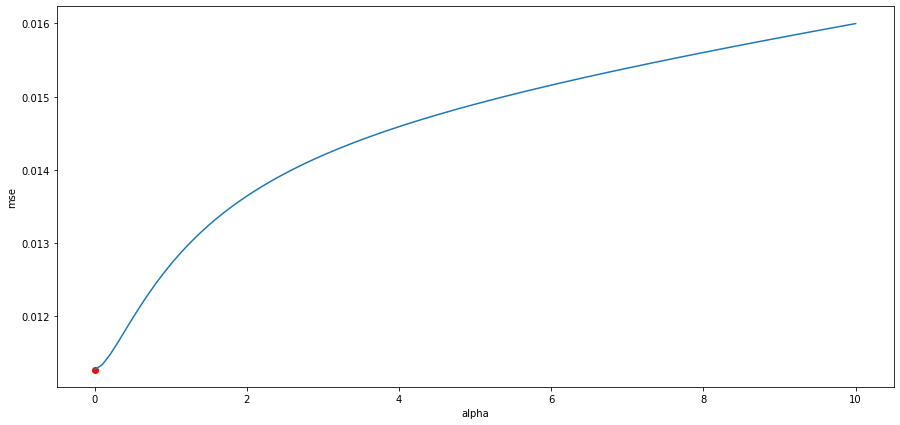

In [15]:
print('Оценка для моделей, которые предсказывают Depth:')
accuracy_model_depth = find_best_model_Ridge(data_with_features, data_with_depth, LeaveOneOut())

# Модель для пердсказания `Width`

Оценка для моделей, которые предсказывают Width:
alpha: 0.9 min error: 0.004939679967163883


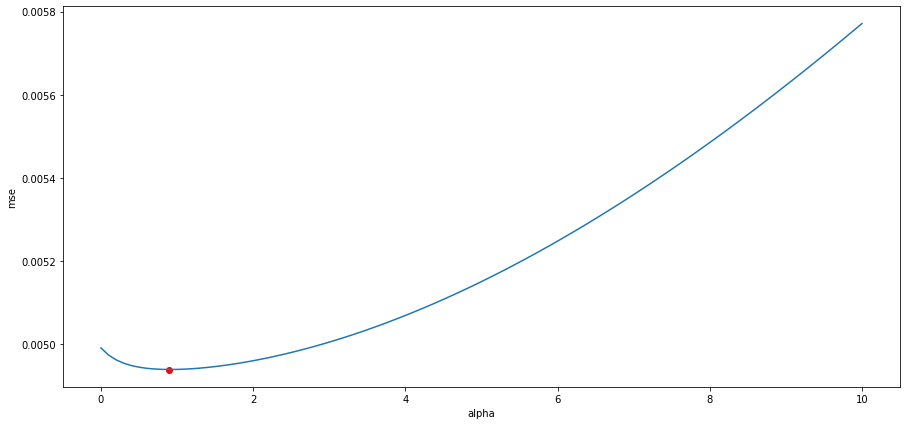

In [16]:
print('Оценка для моделей, которые предсказывают Width:')
accuracy_model_width = find_best_model_Ridge(data_with_features, data_with_width, LeaveOneOut())

In [17]:
# Посмотрим общую ошибку моделей Ridge при решении данной задачи
accuracy_ridge = (accuracy_model_width[1] + accuracy_model_width[1]) / 2
print(accuracy_ridge)

0.004939679967163883


# Модель №2 - Случайный лес

В данном разделе мы будем использовать модель Случайного леса(RandomForestRegressor). Подбор оптимальных гиперпараметров мы будем делать с помощью RandomizedSearchCV. Мы не используем GridSearchCV, в целях экономии ресурсов. Мы можем быть уверены, что лучшие найденные параметры действительно являются лучшим сочетанием оптимальных параметров, поскольку поиск полностью рандомизирован.

Мы напишем 2 модели, одна будет предсказывать `Depth` по признаками, другая - `Width`.

In [18]:
from sklearn.ensemble import RandomForestRegressor # импортируем случайный лес
# импортируем метод для подбора параметров и кросс-валидацию для нейронной сети
from sklearn.model_selection import RandomizedSearchCV, KFold 

# Модель для пердсказания `Depth`

In [19]:
# создаём словарь с параметрами и значениями, по которым нужно выбрать лучший экземпляр
distributions = {
    "n_estimators": [i for i in range(10, 101, 10)],
    "criterion": ['squared_error'],
    "max_features": [i for i in range(1, 5)],
    "min_samples_leaf": [i for i in range(1, 5)],
    "max_depth": [i for i in range(4, 16)],
    "min_samples_split": [i for i in range(2, 5)]
}
# ищем лучший образец
clf_depth = RandomizedSearchCV(RandomForestRegressor(),
                   param_distributions=distributions, 
                   cv=LeaveOneOut(), 
                   scoring='neg_mean_squared_error',
                   n_iter=200)
clf_depth.fit(scaler_data_with_features, data_with_depth)
# сохраняем лучший экземпляр
forest_depth = clf_depth.best_estimator_
# сохраним и выведем среднюю ошибку
accuracy_forest_depth = -clf_depth.best_score_
print('mse', accuracy_forest_depth)

mse 0.004700413884284705


# Модель для пердсказания `Width`

In [20]:
# создаём словарь с параметрами и значениями, по которым нужно выбрать лучший экземпляр
distributions = {
    "n_estimators": [i for i in range(10, 101, 10)],
    "criterion": ['squared_error'],
    "max_features": [i for i in range(1, 5)],
    "min_samples_leaf": [i for i in range(1, 5)],
    "max_depth": [i for i in range(4, 16)],
    "min_samples_split": [i for i in range(2, 5)]
}
# ищем лучший образец
clf_width = RandomizedSearchCV(RandomForestRegressor(),
                   param_distributions=distributions, 
                   cv=LeaveOneOut(), 
                   scoring='neg_mean_squared_error',
                   n_iter=200)
clf_width.fit(scaler_data_with_features, data_with_width)
# сохраняем лучший экземпляр
forest_width = clf_width.best_estimator_
# сохраним и выведем среднюю ошибку
accuracy_forest_width = -clf_width.best_score_
print('mse', accuracy_forest_width)

mse 0.002564031259566161


In [21]:
# Посмотрим общую ошибку моделей RandomForestRegressor при решении данной задачи
accuracy_forest = (accuracy_forest_depth + accuracy_forest_width) / 2
print(accuracy_forest)

0.0036322225719254333


# Модель №3 - Нейронная сеть

Из-за небольшого количества образцов мы будем использовать очень маленькую сеть с двумя слоями. Это обусловлено тем, что чем меньше обучающих данных, тем скорее наступит переобучение, а использование маленькой сети — один из способов борьбы с ним. Так как линейная модель хорошо себя показала, мы будем использовать функции активации `relu`. Для предотвращения переобучения мы будем рассматривать количество эпох как гиперпараметр. Выберём количество эпох для обученися с наименьшей mse на тестовых данных.

In [22]:
from keras import models # Метод для создания модели
from keras import layers # Метод для создания слоёв нейросети

In [23]:
# Функция для построения модели нейронной сети
def build_model():
    # создаём модель
    model = models.Sequential() 
    # добавляем входной слой с функцией активации 'relu'
    model.add(layers.Dense(16, activation='relu', input_shape=(4,)))
    # добавляем второй слой с функцией активации 'relu'
    model.add(layers.Dense(8, activation='relu'))
    # добавляем выходной слой на 2 выхода
    model.add(layers.Dense(2))
    # компилируем модель. В качестве оптимизатора берём алгоритм стохастического градиентного спуска
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
    return model

In [24]:
# Функция, которая является кроссвалидацией.
# Обучение происходит на тренировочных данных, а проверка на тестовых данных
def my_cross_val_score_for_networks(x_data, y_data, splitter, epoch):
    
    list_with_mse = [] # список с mse ошибки модели на каждой итерации
    
    # список перебора индексов для разбиения на тренировочную и тестовую выборки
    for train_index, test_index in splitter.split(x_data):
       
        # разбиение на выборки
        x_train, x_test = x_data[train_index], x_data[test_index] 
        y_train, y_test = y_data[train_index], y_data[test_index]
        
        # объявление модели
        model = build_model()
        
        # обучаем переданную модель
        model.fit(x=x_train, 
                  y=y_train, 
                  epochs=epoch, 
                  batch_size=18)
        # делаем предсказание
        model_predict = model.predict(x_test)
        # считаем mse ошибки
        my_mse_error = mse(y_test, model_predict)
        # добавляем в список
        list_with_mse.append(my_mse_error)
        
    return np.mean(list_with_mse) # возвращаем усредненную mse

In [25]:
list_with_error = [] # список с mse на кросс-валидации каждой модели с разным количеством эпох
list_with_epochs = [i for i in range(50, 251, 10)] # список эпох

for epoch in list_with_epochs:
    list_with_error.append(my_cross_val_score_for_networks(scaler_data_with_features, 
                                              data_with_depth_width, 
                                              KFold(n_splits=4), 
                                              epoch))
accuracy_network = min(list_with_error) # самая лучшая mse
print('Min mse:', accuracy_network)
print('Epochs:', list_with_epochs[list_with_error.index(accuracy_network)]) # оптимальное количество эпох

Epoch 1/50
3/3 [==============================] - 1s 4ms/step - loss: 2.9563 - mse: 2.9563
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 2.6508 - mse: 2.6508
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 2.4596 - mse: 2.4596
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 2.3031 - mse: 2.3031
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 2.1672 - mse: 2.1672
Epoch 6/50
3/3 [==============================] - 0s 3ms/step - loss: 2.0492 - mse: 2.0492
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 1.9402 - mse: 1.9402
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 1.8410 - mse: 1.8410
Epoch 9/50
3/3 [==============================] - 0s 3ms/step - loss: 1.7495 - mse: 1.7495
Epoch 10/50
3/3 [==============================] - 0s 3ms/step - loss: 1.6616 - mse: 1.6616
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 1.5814 - mse: 1.58

3/3 [==============================] - 0s 3ms/step - loss: 0.4196 - mse: 0.4196
Epoch 41/50
3/3 [==============================] - 0s 3ms/step - loss: 0.3976 - mse: 0.3976
Epoch 42/50
3/3 [==============================] - 0s 3ms/step - loss: 0.3762 - mse: 0.3762
Epoch 43/50
3/3 [==============================] - 0s 3ms/step - loss: 0.3571 - mse: 0.3571
Epoch 44/50
3/3 [==============================] - 0s 3ms/step - loss: 0.3377 - mse: 0.3377
Epoch 45/50
3/3 [==============================] - 0s 3ms/step - loss: 0.3191 - mse: 0.3191
Epoch 46/50
3/3 [==============================] - 0s 3ms/step - loss: 0.3008 - mse: 0.3008
Epoch 47/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2843 - mse: 0.2843
Epoch 48/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2683 - mse: 0.2683
Epoch 49/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2508 - mse: 0.2508
Epoch 50/50
3/3 [==============================] - 0s 3ms/step - loss: 0.2358 - mse: 0.2358


3/3 [==============================] - 0s 3ms/step - loss: 0.9476 - mse: 0.9476
Epoch 30/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8934 - mse: 0.8934
Epoch 31/50
3/3 [==============================] - 0s 3ms/step - loss: 0.8385 - mse: 0.8385
Epoch 32/50
3/3 [==============================] - 0s 3ms/step - loss: 0.7885 - mse: 0.7885
Epoch 33/50
3/3 [==============================] - 0s 3ms/step - loss: 0.7388 - mse: 0.7388
Epoch 34/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6914 - mse: 0.6914
Epoch 35/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6455 - mse: 0.6455
Epoch 36/50
3/3 [==============================] - 0s 3ms/step - loss: 0.6008 - mse: 0.6008
Epoch 37/50
3/3 [==============================] - 0s 2ms/step - loss: 0.5593 - mse: 0.5593
Epoch 38/50
3/3 [==============================] - 0s 2ms/step - loss: 0.5194 - mse: 0.5194
Epoch 39/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4817 - mse: 0.4817


Epoch 1/60
3/3 [==============================] - 1s 4ms/step - loss: 2.6303 - mse: 2.6303
Epoch 2/60
3/3 [==============================] - 0s 3ms/step - loss: 2.4120 - mse: 2.4120
Epoch 3/60
3/3 [==============================] - 0s 3ms/step - loss: 2.2701 - mse: 2.2701
Epoch 4/60
3/3 [==============================] - 0s 3ms/step - loss: 2.1530 - mse: 2.1530
Epoch 5/60
3/3 [==============================] - 0s 2ms/step - loss: 2.0496 - mse: 2.0496
Epoch 6/60
3/3 [==============================] - 0s 3ms/step - loss: 1.9552 - mse: 1.9552
Epoch 7/60
3/3 [==============================] - 0s 4ms/step - loss: 1.8685 - mse: 1.8685
Epoch 8/60
3/3 [==============================] - 0s 3ms/step - loss: 1.7849 - mse: 1.7849
Epoch 9/60
3/3 [==============================] - 0s 2ms/step - loss: 1.7044 - mse: 1.7044
Epoch 10/60
3/3 [==============================] - 0s 3ms/step - loss: 1.6270 - mse: 1.6270
Epoch 11/60
3/3 [==============================] - 0s 3ms/step - loss: 1.5529 - mse: 1.55

3/3 [==============================] - 0s 2ms/step - loss: 2.1498 - mse: 2.1498
Epoch 23/60
3/3 [==============================] - 0s 4ms/step - loss: 2.1048 - mse: 2.1048
Epoch 24/60
3/3 [==============================] - 0s 4ms/step - loss: 2.0583 - mse: 2.0583
Epoch 25/60
3/3 [==============================] - 0s 3ms/step - loss: 2.0141 - mse: 2.0141
Epoch 26/60
3/3 [==============================] - 0s 4ms/step - loss: 1.9711 - mse: 1.9711
Epoch 27/60
3/3 [==============================] - 0s 4ms/step - loss: 1.9269 - mse: 1.9269
Epoch 28/60
3/3 [==============================] - 0s 4ms/step - loss: 1.8815 - mse: 1.8815
Epoch 29/60
3/3 [==============================] - 0s 3ms/step - loss: 1.8356 - mse: 1.8356
Epoch 30/60
3/3 [==============================] - 0s 3ms/step - loss: 1.7898 - mse: 1.7898
Epoch 31/60
3/3 [==============================] - 0s 5ms/step - loss: 1.7433 - mse: 1.7433
Epoch 32/60
3/3 [==============================] - 0s 3ms/step - loss: 1.6953 - mse: 1.6953


3/3 [==============================] - 0s 4ms/step - loss: 0.0924 - mse: 0.0924
Epoch 52/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0862 - mse: 0.0862
Epoch 53/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0800 - mse: 0.0800
Epoch 54/60
3/3 [==============================] - 0s 3ms/step - loss: 0.0749 - mse: 0.0749
Epoch 55/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0706 - mse: 0.0706
Epoch 56/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0652 - mse: 0.0652
Epoch 57/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0616 - mse: 0.0616
Epoch 58/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0569 - mse: 0.0569
Epoch 59/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0536 - mse: 0.0536
Epoch 60/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0508 - mse: 0.0508
Epoch 1/70
3/3 [==============================] - 1s 3ms/step - loss: 1.6817 - mse: 1.6817
E

3/3 [==============================] - 0s 2ms/step - loss: 2.1554 - mse: 2.1554
Epoch 11/70
3/3 [==============================] - 0s 3ms/step - loss: 2.0675 - mse: 2.0675
Epoch 12/70
3/3 [==============================] - 0s 3ms/step - loss: 1.9868 - mse: 1.9868
Epoch 13/70
3/3 [==============================] - 0s 3ms/step - loss: 1.9091 - mse: 1.9091
Epoch 14/70
3/3 [==============================] - 0s 2ms/step - loss: 1.8345 - mse: 1.8345
Epoch 15/70
3/3 [==============================] - 0s 3ms/step - loss: 1.7638 - mse: 1.7638
Epoch 16/70
3/3 [==============================] - 0s 4ms/step - loss: 1.6961 - mse: 1.6961
Epoch 17/70
3/3 [==============================] - 0s 4ms/step - loss: 1.6326 - mse: 1.6326
Epoch 18/70
3/3 [==============================] - 0s 4ms/step - loss: 1.5719 - mse: 1.5719
Epoch 19/70
3/3 [==============================] - 0s 3ms/step - loss: 1.5132 - mse: 1.5132
Epoch 20/70
3/3 [==============================] - 0s 4ms/step - loss: 1.4528 - mse: 1.4528


3/3 [==============================] - 0s 4ms/step - loss: 0.9738 - mse: 0.9738
Epoch 30/70
3/3 [==============================] - 0s 4ms/step - loss: 0.9135 - mse: 0.9135
Epoch 31/70
3/3 [==============================] - 0s 4ms/step - loss: 0.8565 - mse: 0.8565
Epoch 32/70
3/3 [==============================] - 0s 3ms/step - loss: 0.8024 - mse: 0.8024
Epoch 33/70
3/3 [==============================] - 0s 3ms/step - loss: 0.7493 - mse: 0.7493
Epoch 34/70
3/3 [==============================] - 0s 3ms/step - loss: 0.7015 - mse: 0.7015
Epoch 35/70
3/3 [==============================] - 0s 3ms/step - loss: 0.6554 - mse: 0.6554
Epoch 36/70
3/3 [==============================] - 0s 3ms/step - loss: 0.6129 - mse: 0.6129
Epoch 37/70
3/3 [==============================] - 0s 3ms/step - loss: 0.5737 - mse: 0.5737
Epoch 38/70
3/3 [==============================] - 0s 3ms/step - loss: 0.5366 - mse: 0.5366
Epoch 39/70
3/3 [==============================] - 0s 3ms/step - loss: 0.5020 - mse: 0.5020


3/3 [==============================] - 0s 3ms/step - loss: 1.1785 - mse: 1.1785
Epoch 49/70
3/3 [==============================] - 0s 3ms/step - loss: 1.1426 - mse: 1.1426
Epoch 50/70
3/3 [==============================] - 0s 3ms/step - loss: 1.1068 - mse: 1.1068
Epoch 51/70
3/3 [==============================] - 0s 2ms/step - loss: 1.0713 - mse: 1.0713
Epoch 52/70
3/3 [==============================] - 0s 3ms/step - loss: 1.0369 - mse: 1.0369
Epoch 53/70
3/3 [==============================] - 0s 3ms/step - loss: 1.0034 - mse: 1.0034
Epoch 54/70
3/3 [==============================] - 0s 4ms/step - loss: 0.9705 - mse: 0.9705
Epoch 55/70
3/3 [==============================] - 0s 5ms/step - loss: 0.9388 - mse: 0.9388
Epoch 56/70
3/3 [==============================] - 0s 3ms/step - loss: 0.9066 - mse: 0.9066
Epoch 57/70
3/3 [==============================] - 0s 3ms/step - loss: 0.8756 - mse: 0.8756
Epoch 58/70
3/3 [==============================] - 0s 3ms/step - loss: 0.8455 - mse: 0.8455


3/3 [==============================] - 0s 3ms/step - loss: 0.8942 - mse: 0.8942
Epoch 68/80
3/3 [==============================] - 0s 2ms/step - loss: 0.8714 - mse: 0.8714
Epoch 69/80
3/3 [==============================] - 0s 4ms/step - loss: 0.8476 - mse: 0.8476
Epoch 70/80
3/3 [==============================] - 0s 3ms/step - loss: 0.8246 - mse: 0.8246
Epoch 71/80
3/3 [==============================] - 0s 4ms/step - loss: 0.8015 - mse: 0.8015
Epoch 72/80
3/3 [==============================] - 0s 4ms/step - loss: 0.7791 - mse: 0.7791
Epoch 73/80
3/3 [==============================] - 0s 3ms/step - loss: 0.7555 - mse: 0.7555
Epoch 74/80
3/3 [==============================] - 0s 3ms/step - loss: 0.7330 - mse: 0.7330
Epoch 75/80
3/3 [==============================] - 0s 3ms/step - loss: 0.7104 - mse: 0.7104
Epoch 76/80
3/3 [==============================] - 0s 3ms/step - loss: 0.6879 - mse: 0.6879
Epoch 77/80
3/3 [==============================] - 0s 3ms/step - loss: 0.6657 - mse: 0.6657


3/3 [==============================] - 0s 2ms/step - loss: 0.1753 - mse: 0.1753
Epoch 77/80
3/3 [==============================] - 0s 2ms/step - loss: 0.1654 - mse: 0.1654
Epoch 78/80
3/3 [==============================] - 0s 2ms/step - loss: 0.1572 - mse: 0.1572
Epoch 79/80
3/3 [==============================] - 0s 2ms/step - loss: 0.1482 - mse: 0.1482
Epoch 80/80
3/3 [==============================] - 0s 3ms/step - loss: 0.1397 - mse: 0.1397
Epoch 1/80
3/3 [==============================] - 1s 3ms/step - loss: 5.1160 - mse: 5.1160
Epoch 2/80
3/3 [==============================] - 0s 3ms/step - loss: 4.7119 - mse: 4.7119
Epoch 3/80
3/3 [==============================] - 0s 3ms/step - loss: 4.4423 - mse: 4.4423
Epoch 4/80
3/3 [==============================] - 0s 4ms/step - loss: 4.2387 - mse: 4.2387
Epoch 5/80
3/3 [==============================] - 0s 4ms/step - loss: 4.0532 - mse: 4.0532
Epoch 6/80
3/3 [==============================] - 0s 4ms/step - loss: 3.8885 - mse: 3.8885
Epoch 

3/3 [==============================] - 0s 4ms/step - loss: 3.1652 - mse: 3.1652
Epoch 6/80
3/3 [==============================] - 0s 5ms/step - loss: 3.0573 - mse: 3.0573
Epoch 7/80
3/3 [==============================] - 0s 4ms/step - loss: 2.9454 - mse: 2.9454
Epoch 8/80
3/3 [==============================] - 0s 3ms/step - loss: 2.8438 - mse: 2.8438
Epoch 9/80
3/3 [==============================] - 0s 3ms/step - loss: 2.7446 - mse: 2.7446
Epoch 10/80
3/3 [==============================] - 0s 3ms/step - loss: 2.6511 - mse: 2.6511
Epoch 11/80
3/3 [==============================] - 0s 3ms/step - loss: 2.5587 - mse: 2.5587
Epoch 12/80
3/3 [==============================] - 0s 3ms/step - loss: 2.4698 - mse: 2.4698
Epoch 13/80
3/3 [==============================] - 0s 4ms/step - loss: 2.3800 - mse: 2.3800
Epoch 14/80
3/3 [==============================] - 0s 3ms/step - loss: 2.2867 - mse: 2.2867
Epoch 15/80
3/3 [==============================] - 0s 2ms/step - loss: 2.2007 - mse: 2.2007
Epoc

3/3 [==============================] - 0s 2ms/step - loss: 0.6673 - mse: 0.6673
Epoch 15/90
3/3 [==============================] - 0s 3ms/step - loss: 0.6187 - mse: 0.6187
Epoch 16/90
3/3 [==============================] - 0s 3ms/step - loss: 0.5723 - mse: 0.5723
Epoch 17/90
3/3 [==============================] - 0s 3ms/step - loss: 0.5285 - mse: 0.5285
Epoch 18/90
3/3 [==============================] - 0s 2ms/step - loss: 0.4862 - mse: 0.4862
Epoch 19/90
3/3 [==============================] - 0s 3ms/step - loss: 0.4453 - mse: 0.4453
Epoch 20/90
3/3 [==============================] - 0s 2ms/step - loss: 0.4070 - mse: 0.4070
Epoch 21/90
3/3 [==============================] - 0s 3ms/step - loss: 0.3709 - mse: 0.3709
Epoch 22/90
3/3 [==============================] - 0s 3ms/step - loss: 0.3378 - mse: 0.3378
Epoch 23/90
3/3 [==============================] - 0s 2ms/step - loss: 0.3061 - mse: 0.3061
Epoch 24/90
3/3 [==============================] - 0s 3ms/step - loss: 0.2778 - mse: 0.2778


3/3 [==============================] - 0s 3ms/step - loss: 0.9580 - mse: 0.9580
Epoch 14/90
3/3 [==============================] - 0s 3ms/step - loss: 0.9041 - mse: 0.9041
Epoch 15/90
3/3 [==============================] - 0s 2ms/step - loss: 0.8533 - mse: 0.8533
Epoch 16/90
3/3 [==============================] - 0s 2ms/step - loss: 0.8054 - mse: 0.8054
Epoch 17/90
3/3 [==============================] - 0s 2ms/step - loss: 0.7614 - mse: 0.7614
Epoch 18/90
3/3 [==============================] - 0s 2ms/step - loss: 0.7195 - mse: 0.7195
Epoch 19/90
3/3 [==============================] - 0s 2ms/step - loss: 0.6802 - mse: 0.6802
Epoch 20/90
3/3 [==============================] - 0s 4ms/step - loss: 0.6442 - mse: 0.6442
Epoch 21/90
3/3 [==============================] - 0s 2ms/step - loss: 0.6103 - mse: 0.6103
Epoch 22/90
3/3 [==============================] - 0s 3ms/step - loss: 0.5787 - mse: 0.5787
Epoch 23/90
3/3 [==============================] - 0s 3ms/step - loss: 0.5487 - mse: 0.5487


3/3 [==============================] - 0s 2ms/step - loss: 1.1933 - mse: 1.1933
Epoch 13/90
3/3 [==============================] - 0s 3ms/step - loss: 1.1447 - mse: 1.1447
Epoch 14/90
3/3 [==============================] - 0s 2ms/step - loss: 1.0975 - mse: 1.0975
Epoch 15/90
3/3 [==============================] - 0s 3ms/step - loss: 1.0528 - mse: 1.0528
Epoch 16/90
3/3 [==============================] - 0s 3ms/step - loss: 1.0078 - mse: 1.0078
Epoch 17/90
3/3 [==============================] - 0s 3ms/step - loss: 0.9661 - mse: 0.9661
Epoch 18/90
3/3 [==============================] - 0s 3ms/step - loss: 0.9229 - mse: 0.9229
Epoch 19/90
3/3 [==============================] - 0s 3ms/step - loss: 0.8827 - mse: 0.8827
Epoch 20/90
3/3 [==============================] - 0s 2ms/step - loss: 0.8406 - mse: 0.8406
Epoch 21/90
3/3 [==============================] - 0s 2ms/step - loss: 0.7973 - mse: 0.7973
Epoch 22/90
3/3 [==============================] - 0s 3ms/step - loss: 0.7563 - mse: 0.7563


3/3 [==============================] - 0s 3ms/step - loss: 2.3025 - mse: 2.3025
Epoch 12/90
3/3 [==============================] - 0s 3ms/step - loss: 2.2219 - mse: 2.2219
Epoch 13/90
3/3 [==============================] - 0s 3ms/step - loss: 2.1358 - mse: 2.1358
Epoch 14/90
3/3 [==============================] - 0s 3ms/step - loss: 2.0514 - mse: 2.0514
Epoch 15/90
3/3 [==============================] - 0s 3ms/step - loss: 1.9709 - mse: 1.9709
Epoch 16/90
3/3 [==============================] - 0s 3ms/step - loss: 1.8934 - mse: 1.8934
Epoch 17/90
3/3 [==============================] - 0s 3ms/step - loss: 1.8182 - mse: 1.8182
Epoch 18/90
3/3 [==============================] - 0s 3ms/step - loss: 1.7466 - mse: 1.7466
Epoch 19/90
3/3 [==============================] - 0s 3ms/step - loss: 1.6773 - mse: 1.6773
Epoch 20/90
3/3 [==============================] - 0s 4ms/step - loss: 1.6072 - mse: 1.6072
Epoch 21/90
3/3 [==============================] - 0s 3ms/step - loss: 1.5398 - mse: 1.5398


3/3 [==============================] - 0s 3ms/step - loss: 2.3743 - mse: 2.3743
Epoch 11/100
3/3 [==============================] - 0s 4ms/step - loss: 2.3191 - mse: 2.3191
Epoch 12/100
3/3 [==============================] - 0s 3ms/step - loss: 2.2672 - mse: 2.2672
Epoch 13/100
3/3 [==============================] - 0s 2ms/step - loss: 2.2161 - mse: 2.2161
Epoch 14/100
3/3 [==============================] - 0s 2ms/step - loss: 2.1648 - mse: 2.1648
Epoch 15/100
3/3 [==============================] - 0s 2ms/step - loss: 2.1153 - mse: 2.1153
Epoch 16/100
3/3 [==============================] - 0s 2ms/step - loss: 2.0669 - mse: 2.0669
Epoch 17/100
3/3 [==============================] - 0s 2ms/step - loss: 2.0184 - mse: 2.0184
Epoch 18/100
3/3 [==============================] - 0s 2ms/step - loss: 1.9718 - mse: 1.9718
Epoch 19/100
3/3 [==============================] - 0s 2ms/step - loss: 1.9254 - mse: 1.9254
Epoch 20/100
3/3 [==============================] - 0s 3ms/step - loss: 1.8799 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0282 - mse: 0.0282
Epoch 99/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0269 - mse: 0.0269
Epoch 100/100
3/3 [==============================] - 0s 2ms/step - loss: 0.0257 - mse: 0.0257
Epoch 1/100
3/3 [==============================] - 1s 3ms/step - loss: 2.6633 - mse: 2.6633
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 2.5505 - mse: 2.5505
Epoch 3/100
3/3 [==============================] - 0s 3ms/step - loss: 2.4769 - mse: 2.4769
Epoch 4/100
3/3 [==============================] - 0s 2ms/step - loss: 2.4141 - mse: 2.4141
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 2.3566 - mse: 2.3566
Epoch 6/100
3/3 [==============================] - 0s 3ms/step - loss: 2.3033 - mse: 2.3033
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 2.2507 - mse: 2.2507
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 2.2022 - mse: 2.20

3/3 [==============================] - 0s 2ms/step - loss: 0.0902 - mse: 0.0902
Epoch 87/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0866 - mse: 0.0866
Epoch 88/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0801 - mse: 0.0801
Epoch 89/100
3/3 [==============================] - 0s 2ms/step - loss: 0.0754 - mse: 0.0754
Epoch 90/100
3/3 [==============================] - 0s 2ms/step - loss: 0.0709 - mse: 0.0709
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0662 - mse: 0.0662
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0620 - mse: 0.0620
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0582 - mse: 0.0582
Epoch 94/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0549 - mse: 0.0549
Epoch 95/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0514 - mse: 0.0514
Epoch 96/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0481 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0172 - mse: 0.0172
Epoch 75/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0163 - mse: 0.0163
Epoch 76/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0152 - mse: 0.0152
Epoch 77/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0145 - mse: 0.0145
Epoch 78/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0133 - mse: 0.0133
Epoch 79/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0126 - mse: 0.0126
Epoch 80/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0122 - mse: 0.0122
Epoch 81/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0112 - mse: 0.0112
Epoch 82/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0104 - mse: 0.0104
Epoch 83/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0103 - mse: 0.0103
Epoch 84/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0094 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.5571 - mse: 0.5571
Epoch 63/100
3/3 [==============================] - 0s 3ms/step - loss: 0.5339 - mse: 0.5339
Epoch 64/100
3/3 [==============================] - 0s 4ms/step - loss: 0.5125 - mse: 0.5125
Epoch 65/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4922 - mse: 0.4922
Epoch 66/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4715 - mse: 0.4715
Epoch 67/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4518 - mse: 0.4518
Epoch 68/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4335 - mse: 0.4335
Epoch 69/100
3/3 [==============================] - 0s 3ms/step - loss: 0.4145 - mse: 0.4145
Epoch 70/100
3/3 [==============================] - 0s 4ms/step - loss: 0.3961 - mse: 0.3961
Epoch 71/100
3/3 [==============================] - 0s 4ms/step - loss: 0.3792 - mse: 0.3792
Epoch 72/100
3/3 [==============================] - 0s 3ms/step - loss: 0.3619 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.1201 - mse: 0.1201
Epoch 51/110
3/3 [==============================] - 0s 3ms/step - loss: 0.1130 - mse: 0.1130
Epoch 52/110
3/3 [==============================] - 0s 4ms/step - loss: 0.1074 - mse: 0.1074
Epoch 53/110
3/3 [==============================] - 0s 3ms/step - loss: 0.1024 - mse: 0.1024
Epoch 54/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0965 - mse: 0.0965
Epoch 55/110
3/3 [==============================] - 0s 5ms/step - loss: 0.0911 - mse: 0.0911
Epoch 56/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0879 - mse: 0.0879
Epoch 57/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0816 - mse: 0.0816
Epoch 58/110
3/3 [==============================] - 0s 3ms/step - loss: 0.0780 - mse: 0.0780
Epoch 59/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0742 - mse: 0.0742
Epoch 60/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0707 - ms

3/3 [==============================] - 0s 5ms/step - loss: 0.7212 - mse: 0.7212
Epoch 29/110
3/3 [==============================] - 0s 4ms/step - loss: 0.6811 - mse: 0.6811
Epoch 30/110
3/3 [==============================] - 0s 5ms/step - loss: 0.6431 - mse: 0.6431
Epoch 31/110
3/3 [==============================] - 0s 4ms/step - loss: 0.6073 - mse: 0.6073
Epoch 32/110
3/3 [==============================] - 0s 4ms/step - loss: 0.5732 - mse: 0.5732
Epoch 33/110
3/3 [==============================] - 0s 4ms/step - loss: 0.5407 - mse: 0.5407
Epoch 34/110
3/3 [==============================] - 0s 4ms/step - loss: 0.5105 - mse: 0.5105
Epoch 35/110
3/3 [==============================] - 0s 5ms/step - loss: 0.4819 - mse: 0.4819
Epoch 36/110
3/3 [==============================] - 0s 4ms/step - loss: 0.4551 - mse: 0.4551
Epoch 37/110
3/3 [==============================] - 0s 4ms/step - loss: 0.4300 - mse: 0.4300
Epoch 38/110
3/3 [==============================] - 0s 4ms/step - loss: 0.4057 - ms

3/3 [==============================] - 0s 4ms/step - loss: 2.0610 - mse: 2.0610
Epoch 7/110
3/3 [==============================] - 0s 3ms/step - loss: 1.9887 - mse: 1.9887
Epoch 8/110
3/3 [==============================] - 0s 4ms/step - loss: 1.9180 - mse: 1.9180
Epoch 9/110
3/3 [==============================] - 0s 4ms/step - loss: 1.8449 - mse: 1.8449
Epoch 10/110
3/3 [==============================] - 0s 4ms/step - loss: 1.7640 - mse: 1.7640
Epoch 11/110
3/3 [==============================] - 0s 4ms/step - loss: 1.6889 - mse: 1.6889
Epoch 12/110
3/3 [==============================] - 0s 3ms/step - loss: 1.6165 - mse: 1.6165
Epoch 13/110
3/3 [==============================] - 0s 3ms/step - loss: 1.5462 - mse: 1.5462
Epoch 14/110
3/3 [==============================] - 0s 4ms/step - loss: 1.4792 - mse: 1.4792
Epoch 15/110
3/3 [==============================] - 0s 4ms/step - loss: 1.4124 - mse: 1.4124
Epoch 16/110
3/3 [==============================] - 0s 4ms/step - loss: 1.3459 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0166 - mse: 0.0166
Epoch 95/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0159 - mse: 0.0159
Epoch 96/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0153 - mse: 0.0153
Epoch 97/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0149 - mse: 0.0149
Epoch 98/110
3/3 [==============================] - 0s 3ms/step - loss: 0.0146 - mse: 0.0146
Epoch 99/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0147 - mse: 0.0147
Epoch 100/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0139 - mse: 0.0139
Epoch 101/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0138 - mse: 0.0138
Epoch 102/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0131 - mse: 0.0131
Epoch 103/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0132 - mse: 0.0132
Epoch 104/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0127

3/3 [==============================] - 0s 4ms/step - loss: 0.0365 - mse: 0.0365
Epoch 73/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0346 - mse: 0.0346
Epoch 74/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0331 - mse: 0.0331
Epoch 75/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0326 - mse: 0.0326
Epoch 76/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0309 - mse: 0.0309
Epoch 77/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0302 - mse: 0.0302
Epoch 78/110
3/3 [==============================] - 0s 3ms/step - loss: 0.0288 - mse: 0.0288
Epoch 79/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0281 - mse: 0.0281
Epoch 80/110
3/3 [==============================] - 0s 3ms/step - loss: 0.0269 - mse: 0.0269
Epoch 81/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0268 - mse: 0.0268
Epoch 82/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0263 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.5783 - mse: 0.5783
Epoch 51/120
3/3 [==============================] - 0s 3ms/step - loss: 0.5621 - mse: 0.5621
Epoch 52/120
3/3 [==============================] - 0s 4ms/step - loss: 0.5462 - mse: 0.5462
Epoch 53/120
3/3 [==============================] - 0s 3ms/step - loss: 0.5321 - mse: 0.5321
Epoch 54/120
3/3 [==============================] - 0s 4ms/step - loss: 0.5167 - mse: 0.5167
Epoch 55/120
3/3 [==============================] - 0s 4ms/step - loss: 0.5036 - mse: 0.5036
Epoch 56/120
3/3 [==============================] - 0s 4ms/step - loss: 0.4890 - mse: 0.4890
Epoch 57/120
3/3 [==============================] - 0s 3ms/step - loss: 0.4768 - mse: 0.4768
Epoch 58/120
3/3 [==============================] - 0s 4ms/step - loss: 0.4645 - mse: 0.4645
Epoch 59/120
3/3 [==============================] - 0s 3ms/step - loss: 0.4532 - mse: 0.4532
Epoch 60/120
3/3 [==============================] - 0s 3ms/step - loss: 0.4417 - ms

3/3 [==============================] - 0s 4ms/step - loss: 1.5688 - mse: 1.5688
Epoch 19/120
3/3 [==============================] - 0s 4ms/step - loss: 1.4953 - mse: 1.4953
Epoch 20/120
3/3 [==============================] - 0s 4ms/step - loss: 1.4267 - mse: 1.4267
Epoch 21/120
3/3 [==============================] - 0s 4ms/step - loss: 1.3571 - mse: 1.3571
Epoch 22/120
3/3 [==============================] - 0s 3ms/step - loss: 1.2937 - mse: 1.2937
Epoch 23/120
3/3 [==============================] - 0s 4ms/step - loss: 1.2344 - mse: 1.2344
Epoch 24/120
3/3 [==============================] - 0s 4ms/step - loss: 1.1825 - mse: 1.1825
Epoch 25/120
3/3 [==============================] - 0s 3ms/step - loss: 1.1345 - mse: 1.1345
Epoch 26/120
3/3 [==============================] - 0s 4ms/step - loss: 1.0943 - mse: 1.0943
Epoch 27/120
3/3 [==============================] - 0s 3ms/step - loss: 1.0567 - mse: 1.0567
Epoch 28/120
3/3 [==============================] - 0s 4ms/step - loss: 1.0254 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0094 - mse: 0.0094
Epoch 107/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0086 - mse: 0.0086
Epoch 108/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0082 - mse: 0.0082
Epoch 109/120
3/3 [==============================] - 0s 3ms/step - loss: 0.0077 - mse: 0.0077
Epoch 110/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0076 - mse: 0.0076
Epoch 111/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0067 - mse: 0.0067
Epoch 112/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0064 - mse: 0.0064
Epoch 113/120
3/3 [==============================] - 0s 3ms/step - loss: 0.0062 - mse: 0.0062
Epoch 114/120
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058
Epoch 115/120
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058
Epoch 116/120
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0854 - mse: 0.0854
Epoch 75/120
3/3 [==============================] - 0s 3ms/step - loss: 0.0794 - mse: 0.0794
Epoch 76/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0759 - mse: 0.0759
Epoch 77/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0715 - mse: 0.0715
Epoch 78/120
3/3 [==============================] - 0s 3ms/step - loss: 0.0676 - mse: 0.0676
Epoch 79/120
3/3 [==============================] - 0s 3ms/step - loss: 0.0644 - mse: 0.0644
Epoch 80/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0619 - mse: 0.0619
Epoch 81/120
3/3 [==============================] - 0s 3ms/step - loss: 0.0576 - mse: 0.0576
Epoch 82/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0554 - mse: 0.0554
Epoch 83/120
3/3 [==============================] - 0s 2ms/step - loss: 0.0519 - mse: 0.0519
Epoch 84/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0489 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.5095 - mse: 0.5095
Epoch 43/120
3/3 [==============================] - 0s 4ms/step - loss: 0.4801 - mse: 0.4801
Epoch 44/120
3/3 [==============================] - 0s 4ms/step - loss: 0.4536 - mse: 0.4536
Epoch 45/120
3/3 [==============================] - 0s 4ms/step - loss: 0.4291 - mse: 0.4291
Epoch 46/120
3/3 [==============================] - 0s 3ms/step - loss: 0.4048 - mse: 0.4048
Epoch 47/120
3/3 [==============================] - 0s 3ms/step - loss: 0.3822 - mse: 0.3822
Epoch 48/120
3/3 [==============================] - 0s 4ms/step - loss: 0.3602 - mse: 0.3602
Epoch 49/120
3/3 [==============================] - 0s 3ms/step - loss: 0.3412 - mse: 0.3412
Epoch 50/120
3/3 [==============================] - 0s 4ms/step - loss: 0.3194 - mse: 0.3194
Epoch 51/120
3/3 [==============================] - 0s 4ms/step - loss: 0.3010 - mse: 0.3010
Epoch 52/120
3/3 [==============================] - 0s 3ms/step - loss: 0.2826 - ms

3/3 [==============================] - 0s 4ms/step - loss: 1.0107 - mse: 1.0107
Epoch 11/130
3/3 [==============================] - 0s 3ms/step - loss: 0.9415 - mse: 0.9415
Epoch 12/130
3/3 [==============================] - 0s 3ms/step - loss: 0.8802 - mse: 0.8802
Epoch 13/130
3/3 [==============================] - 0s 3ms/step - loss: 0.8216 - mse: 0.8216
Epoch 14/130
3/3 [==============================] - 0s 4ms/step - loss: 0.7690 - mse: 0.7690
Epoch 15/130
3/3 [==============================] - 0s 3ms/step - loss: 0.7206 - mse: 0.7206
Epoch 16/130
3/3 [==============================] - 0s 4ms/step - loss: 0.6763 - mse: 0.6763
Epoch 17/130
3/3 [==============================] - 0s 3ms/step - loss: 0.6362 - mse: 0.6362
Epoch 18/130
3/3 [==============================] - 0s 4ms/step - loss: 0.6000 - mse: 0.6000
Epoch 19/130
3/3 [==============================] - 0s 3ms/step - loss: 0.5669 - mse: 0.5669
Epoch 20/130
3/3 [==============================] - 0s 3ms/step - loss: 0.5376 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0273 - mse: 0.0273
Epoch 99/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0260 - mse: 0.0260
Epoch 100/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0257 - mse: 0.0257
Epoch 101/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0243 - mse: 0.0243
Epoch 102/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0236 - mse: 0.0236
Epoch 103/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0230 - mse: 0.0230
Epoch 104/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0243 - mse: 0.0243
Epoch 105/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0221 - mse: 0.0221
Epoch 106/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0226 - mse: 0.0226
Epoch 107/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0208 - mse: 0.0208
Epoch 108/130
3/3 [==============================] - 0s 3ms/step - loss: 0.

Epoch 56/130
3/3 [==============================] - 0s 4ms/step - loss: 0.1134 - mse: 0.1134
Epoch 57/130
3/3 [==============================] - 0s 4ms/step - loss: 0.1050 - mse: 0.1050
Epoch 58/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0991 - mse: 0.0991
Epoch 59/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0938 - mse: 0.0938
Epoch 60/130
3/3 [==============================] - 0s 6ms/step - loss: 0.0885 - mse: 0.0885
Epoch 61/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0833 - mse: 0.0833
Epoch 62/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0780 - mse: 0.0780
Epoch 63/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0745 - mse: 0.0745
Epoch 64/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0701 - mse: 0.0701
Epoch 65/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0654 - mse: 0.0654
Epoch 66/130
3/3 [==============================] - 0s 4ms/step - loss

3/3 [==============================] - 0s 4ms/step - loss: 1.8209 - mse: 1.8209
Epoch 14/130
3/3 [==============================] - 0s 4ms/step - loss: 1.7685 - mse: 1.7685
Epoch 15/130
3/3 [==============================] - 0s 3ms/step - loss: 1.7169 - mse: 1.7169
Epoch 16/130
3/3 [==============================] - 0s 4ms/step - loss: 1.6673 - mse: 1.6673
Epoch 17/130
3/3 [==============================] - 0s 4ms/step - loss: 1.6201 - mse: 1.6201
Epoch 18/130
3/3 [==============================] - 0s 4ms/step - loss: 1.5758 - mse: 1.5758
Epoch 19/130
3/3 [==============================] - 0s 3ms/step - loss: 1.5362 - mse: 1.5362
Epoch 20/130
3/3 [==============================] - 0s 3ms/step - loss: 1.5007 - mse: 1.5007
Epoch 21/130
3/3 [==============================] - 0s 4ms/step - loss: 1.4668 - mse: 1.4668
Epoch 22/130
3/3 [==============================] - 0s 3ms/step - loss: 1.4330 - mse: 1.4330
Epoch 23/130
3/3 [==============================] - 0s 4ms/step - loss: 1.4008 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0378 - mse: 0.0378
Epoch 102/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0368 - mse: 0.0368
Epoch 103/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0353 - mse: 0.0353
Epoch 104/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0340 - mse: 0.0340
Epoch 105/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0328 - mse: 0.0328
Epoch 106/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0317 - mse: 0.0317
Epoch 107/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0309 - mse: 0.0309
Epoch 108/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0298 - mse: 0.0298
Epoch 109/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0287 - mse: 0.0287
Epoch 110/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0275 - mse: 0.0275
Epoch 111/130
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.3293 - mse: 0.3293
Epoch 60/130
3/3 [==============================] - 0s 2ms/step - loss: 0.3050 - mse: 0.3050
Epoch 61/130
3/3 [==============================] - 0s 3ms/step - loss: 0.2843 - mse: 0.2843
Epoch 62/130
3/3 [==============================] - 0s 3ms/step - loss: 0.2646 - mse: 0.2646
Epoch 63/130
3/3 [==============================] - 0s 4ms/step - loss: 0.2454 - mse: 0.2454
Epoch 64/130
3/3 [==============================] - 0s 3ms/step - loss: 0.2284 - mse: 0.2284
Epoch 65/130
3/3 [==============================] - 0s 3ms/step - loss: 0.2114 - mse: 0.2114
Epoch 66/130
3/3 [==============================] - 0s 4ms/step - loss: 0.1967 - mse: 0.1967
Epoch 67/130
3/3 [==============================] - 0s 3ms/step - loss: 0.1823 - mse: 0.1823
Epoch 68/130
3/3 [==============================] - 0s 3ms/step - loss: 0.1689 - mse: 0.1689
Epoch 69/130
3/3 [==============================] - 0s 4ms/step - loss: 0.1563 - ms

Epoch 17/140
3/3 [==============================] - 0s 21ms/step - loss: 0.4026 - mse: 0.4026
Epoch 18/140
3/3 [==============================] - 0s 4ms/step - loss: 0.3834 - mse: 0.3834
Epoch 19/140
3/3 [==============================] - 0s 4ms/step - loss: 0.3657 - mse: 0.3657
Epoch 20/140
3/3 [==============================] - 0s 4ms/step - loss: 0.3500 - mse: 0.3500
Epoch 21/140
3/3 [==============================] - 0s 4ms/step - loss: 0.3367 - mse: 0.3367
Epoch 22/140
3/3 [==============================] - 0s 3ms/step - loss: 0.3208 - mse: 0.3208
Epoch 23/140
3/3 [==============================] - 0s 3ms/step - loss: 0.3055 - mse: 0.3055
Epoch 24/140
3/3 [==============================] - 0s 3ms/step - loss: 0.2926 - mse: 0.2926
Epoch 25/140
3/3 [==============================] - 0s 3ms/step - loss: 0.2783 - mse: 0.2783
Epoch 26/140
3/3 [==============================] - 0s 3ms/step - loss: 0.2669 - mse: 0.2669
Epoch 27/140
3/3 [==============================] - 0s 4ms/step - los

3/3 [==============================] - 0s 4ms/step - loss: 0.0251 - mse: 0.0251
Epoch 106/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0227 - mse: 0.0227
Epoch 107/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0243 - mse: 0.0243
Epoch 108/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0230 - mse: 0.0230
Epoch 109/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0211 - mse: 0.0211
Epoch 110/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0214 - mse: 0.0214
Epoch 111/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0203 - mse: 0.0203
Epoch 112/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0199 - mse: 0.0199
Epoch 113/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0196 - mse: 0.0196
Epoch 114/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0203 - mse: 0.0203
Epoch 115/140
3/3 [==============================] - 0s 3ms/step - loss: 0

Epoch 53/140
3/3 [==============================] - 0s 3ms/step - loss: 0.1009 - mse: 0.1009
Epoch 54/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0952 - mse: 0.0952
Epoch 55/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0903 - mse: 0.0903
Epoch 56/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0856 - mse: 0.0856
Epoch 57/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0816 - mse: 0.0816
Epoch 58/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0771 - mse: 0.0771
Epoch 59/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0719 - mse: 0.0719
Epoch 60/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0690 - mse: 0.0690
Epoch 61/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0646 - mse: 0.0646
Epoch 62/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0614 - mse: 0.0614
Epoch 63/140
3/3 [==============================] - 0s 3ms/step - loss

3/3 [==============================] - 0s 3ms/step - loss: 0.0060 - mse: 0.0060
Epoch 1/140
3/3 [==============================] - 1s 2ms/step - loss: 3.3332 - mse: 3.3332
Epoch 2/140
3/3 [==============================] - 0s 3ms/step - loss: 3.1465 - mse: 3.1465
Epoch 3/140
3/3 [==============================] - 0s 3ms/step - loss: 3.0065 - mse: 3.0065
Epoch 4/140
3/3 [==============================] - 0s 3ms/step - loss: 2.8855 - mse: 2.8855
Epoch 5/140
3/3 [==============================] - 0s 4ms/step - loss: 2.7769 - mse: 2.7769
Epoch 6/140
3/3 [==============================] - 0s 4ms/step - loss: 2.6774 - mse: 2.6774
Epoch 7/140
3/3 [==============================] - 0s 3ms/step - loss: 2.5767 - mse: 2.5767
Epoch 8/140
3/3 [==============================] - 0s 4ms/step - loss: 2.4830 - mse: 2.4830
Epoch 9/140
3/3 [==============================] - 0s 4ms/step - loss: 2.3940 - mse: 2.3940
Epoch 10/140
3/3 [==============================] - 0s 3ms/step - loss: 2.3099 - mse: 2.3099

3/3 [==============================] - 0s 4ms/step - loss: 0.0227 - mse: 0.0227
Epoch 89/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0218 - mse: 0.0218
Epoch 90/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0217 - mse: 0.0217
Epoch 91/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0204 - mse: 0.0204
Epoch 92/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0198 - mse: 0.0198
Epoch 93/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0196 - mse: 0.0196
Epoch 94/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0187 - mse: 0.0187
Epoch 95/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0184 - mse: 0.0184
Epoch 96/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0177 - mse: 0.0177
Epoch 97/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0171 - mse: 0.0171
Epoch 98/140
3/3 [==============================] - 0s 2ms/step - loss: 0.0170 - ms

3/3 [==============================] - 0s 19ms/step - loss: 1.0766 - mse: 1.0766
Epoch 36/140
3/3 [==============================] - 0s 3ms/step - loss: 1.0459 - mse: 1.0459
Epoch 37/140
3/3 [==============================] - 0s 3ms/step - loss: 1.0157 - mse: 1.0157
Epoch 38/140
3/3 [==============================] - 0s 3ms/step - loss: 0.9879 - mse: 0.9879
Epoch 39/140
3/3 [==============================] - 0s 4ms/step - loss: 0.9601 - mse: 0.9601
Epoch 40/140
3/3 [==============================] - 0s 3ms/step - loss: 0.9335 - mse: 0.9335
Epoch 41/140
3/3 [==============================] - 0s 3ms/step - loss: 0.9080 - mse: 0.9080
Epoch 42/140
3/3 [==============================] - 0s 3ms/step - loss: 0.8839 - mse: 0.8839
Epoch 43/140
3/3 [==============================] - 0s 3ms/step - loss: 0.8598 - mse: 0.8598
Epoch 44/140
3/3 [==============================] - 0s 4ms/step - loss: 0.8360 - mse: 0.8360
Epoch 45/140
3/3 [==============================] - 0s 4ms/step - loss: 0.8143 - m

Epoch 123/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0353 - mse: 0.0353
Epoch 124/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0344 - mse: 0.0344
Epoch 125/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0336 - mse: 0.0336
Epoch 126/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0322 - mse: 0.0322
Epoch 127/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0317 - mse: 0.0317
Epoch 128/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0306 - mse: 0.0306
Epoch 129/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0300 - mse: 0.0300
Epoch 130/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0292 - mse: 0.0292
Epoch 131/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0287 - mse: 0.0287
Epoch 132/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0281 - mse: 0.0281
Epoch 133/140
3/3 [==============================] - 0s 4ms/

Epoch 71/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0711 - mse: 0.0711
Epoch 72/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0672 - mse: 0.0672
Epoch 73/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0651 - mse: 0.0651
Epoch 74/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0629 - mse: 0.0629
Epoch 75/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0603 - mse: 0.0603
Epoch 76/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0578 - mse: 0.0578
Epoch 77/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0568 - mse: 0.0568
Epoch 78/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0544 - mse: 0.0544
Epoch 79/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0532 - mse: 0.0532
Epoch 80/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0507 - mse: 0.0507
Epoch 81/150
3/3 [==============================] - 0s 4ms/step - loss

3/3 [==============================] - 0s 3ms/step - loss: 1.9502 - mse: 1.9502
Epoch 9/150
3/3 [==============================] - 0s 3ms/step - loss: 1.8476 - mse: 1.8476
Epoch 10/150
3/3 [==============================] - 0s 3ms/step - loss: 1.7526 - mse: 1.7526
Epoch 11/150
3/3 [==============================] - 0s 4ms/step - loss: 1.6621 - mse: 1.6621
Epoch 12/150
3/3 [==============================] - 0s 3ms/step - loss: 1.5766 - mse: 1.5766
Epoch 13/150
3/3 [==============================] - 0s 2ms/step - loss: 1.4913 - mse: 1.4913
Epoch 14/150
3/3 [==============================] - 0s 3ms/step - loss: 1.4122 - mse: 1.4122
Epoch 15/150
3/3 [==============================] - 0s 3ms/step - loss: 1.3413 - mse: 1.3413
Epoch 16/150
3/3 [==============================] - 0s 3ms/step - loss: 1.2735 - mse: 1.2735
Epoch 17/150
3/3 [==============================] - 0s 4ms/step - loss: 1.2114 - mse: 1.2114
Epoch 18/150
3/3 [==============================] - 0s 2ms/step - loss: 1.1508 - mse

3/3 [==============================] - 0s 3ms/step - loss: 0.0097 - mse: 0.0097
Epoch 97/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0090 - mse: 0.0090
Epoch 98/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0089 - mse: 0.0089
Epoch 99/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086
Epoch 100/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0090 - mse: 0.0090
Epoch 101/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0084 - mse: 0.0084
Epoch 102/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0087 - mse: 0.0087
Epoch 103/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0081 - mse: 0.0081
Epoch 104/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076
Epoch 105/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076
Epoch 106/150
3/3 [==============================] - 0s 3ms/step - loss: 0.00

3/3 [==============================] - 0s 3ms/step - loss: 0.4336 - mse: 0.4336
Epoch 34/150
3/3 [==============================] - 0s 3ms/step - loss: 0.4074 - mse: 0.4074
Epoch 35/150
3/3 [==============================] - 0s 3ms/step - loss: 0.3844 - mse: 0.3844
Epoch 36/150
3/3 [==============================] - 0s 4ms/step - loss: 0.3627 - mse: 0.3627
Epoch 37/150
3/3 [==============================] - 0s 3ms/step - loss: 0.3425 - mse: 0.3425
Epoch 38/150
3/3 [==============================] - 0s 4ms/step - loss: 0.3237 - mse: 0.3237
Epoch 39/150
3/3 [==============================] - 0s 3ms/step - loss: 0.3064 - mse: 0.3064
Epoch 40/150
3/3 [==============================] - 0s 2ms/step - loss: 0.2881 - mse: 0.2881
Epoch 41/150
3/3 [==============================] - 0s 4ms/step - loss: 0.2712 - mse: 0.2712
Epoch 42/150
3/3 [==============================] - 0s 3ms/step - loss: 0.2573 - mse: 0.2573
Epoch 43/150
3/3 [==============================] - 0s 3ms/step - loss: 0.2427 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 0.0059
Epoch 122/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058
Epoch 123/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 124/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0058 - mse: 0.0058
Epoch 125/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0061 - mse: 0.0061
Epoch 126/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058
Epoch 127/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 0.0055
Epoch 128/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 129/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055
Epoch 130/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053
Epoch 131/150
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.2132 - mse: 0.2132
Epoch 60/150
3/3 [==============================] - 0s 3ms/step - loss: 0.1996 - mse: 0.1996
Epoch 61/150
3/3 [==============================] - 0s 3ms/step - loss: 0.1877 - mse: 0.1877
Epoch 62/150
3/3 [==============================] - 0s 3ms/step - loss: 0.1751 - mse: 0.1751
Epoch 63/150
3/3 [==============================] - 0s 4ms/step - loss: 0.1639 - mse: 0.1639
Epoch 64/150
3/3 [==============================] - 0s 3ms/step - loss: 0.1532 - mse: 0.1532
Epoch 65/150
3/3 [==============================] - 0s 4ms/step - loss: 0.1439 - mse: 0.1439
Epoch 66/150
3/3 [==============================] - 0s 3ms/step - loss: 0.1349 - mse: 0.1349
Epoch 67/150
3/3 [==============================] - 0s 3ms/step - loss: 0.1260 - mse: 0.1260
Epoch 68/150
3/3 [==============================] - 0s 3ms/step - loss: 0.1184 - mse: 0.1184
Epoch 69/150
3/3 [==============================] - 0s 3ms/step - loss: 0.1110 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 0.0091
Epoch 147/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0089 - mse: 0.0089
Epoch 148/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0088 - mse: 0.0088
Epoch 149/150
3/3 [==============================] - 0s 3ms/step - loss: 0.0085 - mse: 0.0085
Epoch 150/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0088 - mse: 0.0088
Epoch 1/160
3/3 [==============================] - 1s 4ms/step - loss: 2.5344 - mse: 2.5344
Epoch 2/160
3/3 [==============================] - 0s 4ms/step - loss: 2.3862 - mse: 2.3862
Epoch 3/160
3/3 [==============================] - 0s 4ms/step - loss: 2.3094 - mse: 2.3094
Epoch 4/160
3/3 [==============================] - 0s 3ms/step - loss: 2.2417 - mse: 2.2417
Epoch 5/160
3/3 [==============================] - 0s 4ms/step - loss: 2.1752 - mse: 2.1752
Epoch 6/160
3/3 [==============================] - 0s 3ms/step - loss: 2.1103 - mse:

3/3 [==============================] - 0s 3ms/step - loss: 0.0577 - mse: 0.0577
Epoch 85/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0558 - mse: 0.0558
Epoch 86/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0556 - mse: 0.0556
Epoch 87/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0542 - mse: 0.0542
Epoch 88/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0532 - mse: 0.0532
Epoch 89/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0521 - mse: 0.0521
Epoch 90/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0527 - mse: 0.0527
Epoch 91/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0512 - mse: 0.0512
Epoch 92/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0497 - mse: 0.0497
Epoch 93/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0498 - mse: 0.0498
Epoch 94/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0484 - ms

3/3 [==============================] - 0s 3ms/step - loss: 1.7259 - mse: 1.7259
Epoch 12/160
3/3 [==============================] - 0s 3ms/step - loss: 1.6589 - mse: 1.6589
Epoch 13/160
3/3 [==============================] - 0s 3ms/step - loss: 1.5918 - mse: 1.5918
Epoch 14/160
3/3 [==============================] - 0s 3ms/step - loss: 1.5274 - mse: 1.5274
Epoch 15/160
3/3 [==============================] - 0s 4ms/step - loss: 1.4599 - mse: 1.4599
Epoch 16/160
3/3 [==============================] - 0s 3ms/step - loss: 1.3899 - mse: 1.3899
Epoch 17/160
3/3 [==============================] - 0s 3ms/step - loss: 1.3236 - mse: 1.3236
Epoch 18/160
3/3 [==============================] - 0s 4ms/step - loss: 1.2598 - mse: 1.2598
Epoch 19/160
3/3 [==============================] - 0s 4ms/step - loss: 1.1932 - mse: 1.1932
Epoch 20/160
3/3 [==============================] - 0s 4ms/step - loss: 1.1311 - mse: 1.1311
Epoch 21/160
3/3 [==============================] - 0s 3ms/step - loss: 1.0714 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0113 - mse: 0.0113
Epoch 100/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0106 - mse: 0.0106
Epoch 101/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0105 - mse: 0.0105
Epoch 102/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101
Epoch 103/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101
Epoch 104/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0096 - mse: 0.0096
Epoch 105/160
3/3 [==============================] - 0s 2ms/step - loss: 0.0093 - mse: 0.0093
Epoch 106/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 0.0091
Epoch 107/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0087 - mse: 0.0087
Epoch 108/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0087 - mse: 0.0087
Epoch 109/160
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.3754 - mse: 0.3754
Epoch 27/160
3/3 [==============================] - 0s 4ms/step - loss: 0.3505 - mse: 0.3505
Epoch 28/160
3/3 [==============================] - 0s 3ms/step - loss: 0.3264 - mse: 0.3264
Epoch 29/160
3/3 [==============================] - 0s 4ms/step - loss: 0.3018 - mse: 0.3018
Epoch 30/160
3/3 [==============================] - 0s 4ms/step - loss: 0.2777 - mse: 0.2777
Epoch 31/160
3/3 [==============================] - 0s 3ms/step - loss: 0.2579 - mse: 0.2579
Epoch 32/160
3/3 [==============================] - 0s 4ms/step - loss: 0.2391 - mse: 0.2391
Epoch 33/160
3/3 [==============================] - 0s 4ms/step - loss: 0.2227 - mse: 0.2227
Epoch 34/160
3/3 [==============================] - 0s 4ms/step - loss: 0.2079 - mse: 0.2079
Epoch 35/160
3/3 [==============================] - 0s 4ms/step - loss: 0.1941 - mse: 0.1941
Epoch 36/160
3/3 [==============================] - 0s 3ms/step - loss: 0.1831 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0083 - mse: 0.0083
Epoch 115/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0081 - mse: 0.0081
Epoch 116/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0077 - mse: 0.0077
Epoch 117/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0077 - mse: 0.0077
Epoch 118/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0080 - mse: 0.0080
Epoch 119/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0073 - mse: 0.0073
Epoch 120/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0075 - mse: 0.0075
Epoch 121/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0075 - mse: 0.0075
Epoch 122/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0078 - mse: 0.0078
Epoch 123/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0077 - mse: 0.0077
Epoch 124/160
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 1.7854 - mse: 1.7854
Epoch 42/160
3/3 [==============================] - 0s 3ms/step - loss: 1.7634 - mse: 1.7634
Epoch 43/160
3/3 [==============================] - 0s 3ms/step - loss: 1.7417 - mse: 1.7417
Epoch 44/160
3/3 [==============================] - 0s 3ms/step - loss: 1.7210 - mse: 1.7210
Epoch 45/160
3/3 [==============================] - 0s 4ms/step - loss: 1.6995 - mse: 1.6995
Epoch 46/160
3/3 [==============================] - 0s 3ms/step - loss: 1.6787 - mse: 1.6787
Epoch 47/160
3/3 [==============================] - 0s 4ms/step - loss: 1.6575 - mse: 1.6575
Epoch 48/160
3/3 [==============================] - 0s 3ms/step - loss: 1.6372 - mse: 1.6372
Epoch 49/160
3/3 [==============================] - 0s 3ms/step - loss: 1.6161 - mse: 1.6161
Epoch 50/160
3/3 [==============================] - 0s 3ms/step - loss: 1.5957 - mse: 1.5957
Epoch 51/160
3/3 [==============================] - 0s 4ms/step - loss: 1.5752 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.4905 - mse: 0.4905
Epoch 129/160
3/3 [==============================] - 0s 3ms/step - loss: 0.4826 - mse: 0.4826
Epoch 130/160
3/3 [==============================] - 0s 3ms/step - loss: 0.4748 - mse: 0.4748
Epoch 131/160
3/3 [==============================] - 0s 4ms/step - loss: 0.4672 - mse: 0.4672
Epoch 132/160
3/3 [==============================] - 0s 3ms/step - loss: 0.4598 - mse: 0.4598
Epoch 133/160
3/3 [==============================] - 0s 3ms/step - loss: 0.4524 - mse: 0.4524
Epoch 134/160
3/3 [==============================] - 0s 3ms/step - loss: 0.4451 - mse: 0.4451
Epoch 135/160
3/3 [==============================] - 0s 3ms/step - loss: 0.4378 - mse: 0.4378
Epoch 136/160
3/3 [==============================] - 0s 3ms/step - loss: 0.4307 - mse: 0.4307
Epoch 137/160
3/3 [==============================] - 0s 3ms/step - loss: 0.4236 - mse: 0.4236
Epoch 138/160
3/3 [==============================] - 0s 3ms/step - loss: 0

Epoch 56/170
3/3 [==============================] - 0s 3ms/step - loss: 1.0824 - mse: 1.0824
Epoch 57/170
3/3 [==============================] - 0s 3ms/step - loss: 1.0530 - mse: 1.0530
Epoch 58/170
3/3 [==============================] - 0s 3ms/step - loss: 1.0126 - mse: 1.0126
Epoch 59/170
3/3 [==============================] - 0s 3ms/step - loss: 0.9724 - mse: 0.9724
Epoch 60/170
3/3 [==============================] - 0s 4ms/step - loss: 0.9263 - mse: 0.9263
Epoch 61/170
3/3 [==============================] - 0s 3ms/step - loss: 0.8826 - mse: 0.8826
Epoch 62/170
3/3 [==============================] - 0s 3ms/step - loss: 0.8422 - mse: 0.8422
Epoch 63/170
3/3 [==============================] - 0s 3ms/step - loss: 0.8040 - mse: 0.8040
Epoch 64/170
3/3 [==============================] - 0s 4ms/step - loss: 0.7682 - mse: 0.7682
Epoch 65/170
3/3 [==============================] - 0s 3ms/step - loss: 0.7331 - mse: 0.7331
Epoch 66/170
3/3 [==============================] - 0s 3ms/step - loss

3/3 [==============================] - 0s 3ms/step - loss: 0.0199 - mse: 0.0199
Epoch 144/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0197 - mse: 0.0197
Epoch 145/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0195 - mse: 0.0195
Epoch 146/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0185 - mse: 0.0185
Epoch 147/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0182 - mse: 0.0182
Epoch 148/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0175 - mse: 0.0175
Epoch 149/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0181 - mse: 0.0181
Epoch 150/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0171 - mse: 0.0171
Epoch 151/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0167 - mse: 0.0167
Epoch 152/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0160 - mse: 0.0160
Epoch 153/170
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.0842 - mse: 0.0842
Epoch 62/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0802 - mse: 0.0802
Epoch 63/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0762 - mse: 0.0762
Epoch 64/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0733 - mse: 0.0733
Epoch 65/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0699 - mse: 0.0699
Epoch 66/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0667 - mse: 0.0667
Epoch 67/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0629 - mse: 0.0629
Epoch 68/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0601 - mse: 0.0601
Epoch 69/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0573 - mse: 0.0573
Epoch 70/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0548 - mse: 0.0548
Epoch 71/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0528 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038
Epoch 149/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032
Epoch 150/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030
Epoch 151/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030
Epoch 152/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0034 - mse: 0.0034
Epoch 153/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 154/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032
Epoch 155/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 156/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0030 - mse: 0.0030
Epoch 157/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029
Epoch 158/170
3/3 [==============================] - 0s 5ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.1291 - mse: 0.1291
Epoch 67/170
3/3 [==============================] - 0s 4ms/step - loss: 0.1194 - mse: 0.1194
Epoch 68/170
3/3 [==============================] - 0s 3ms/step - loss: 0.1098 - mse: 0.1098
Epoch 69/170
3/3 [==============================] - 0s 4ms/step - loss: 0.1011 - mse: 0.1011
Epoch 70/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0934 - mse: 0.0934
Epoch 71/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0862 - mse: 0.0862
Epoch 72/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0790 - mse: 0.0790
Epoch 73/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0739 - mse: 0.0739
Epoch 74/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0675 - mse: 0.0675
Epoch 75/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0628 - mse: 0.0628
Epoch 76/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0582 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 154/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0044 - mse: 0.0044
Epoch 155/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0044 - mse: 0.0044
Epoch 156/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0043 - mse: 0.0043
Epoch 157/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 0.0045
Epoch 158/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041
Epoch 159/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0043 - mse: 0.0043
Epoch 160/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0040 - mse: 0.0040
Epoch 161/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040
Epoch 162/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0046 - mse: 0.0046
Epoch 163/170
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.0433 - mse: 0.0433
Epoch 72/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0402 - mse: 0.0402
Epoch 73/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0381 - mse: 0.0381
Epoch 74/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0360 - mse: 0.0360
Epoch 75/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0345 - mse: 0.0345
Epoch 76/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0329 - mse: 0.0329
Epoch 77/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0308 - mse: 0.0308
Epoch 78/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0300 - mse: 0.0300
Epoch 79/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0277 - mse: 0.0277
Epoch 80/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0263 - mse: 0.0263
Epoch 81/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0252 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056
Epoch 159/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058
Epoch 160/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0061 - mse: 0.0061
Epoch 161/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 0.0051
Epoch 162/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055
Epoch 163/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056
Epoch 164/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 165/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 166/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 0.0051
Epoch 167/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 168/170
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.0815 - mse: 0.0815
Epoch 77/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0787 - mse: 0.0787
Epoch 78/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0762 - mse: 0.0762
Epoch 79/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0734 - mse: 0.0734
Epoch 80/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0714 - mse: 0.0714
Epoch 81/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0692 - mse: 0.0692
Epoch 82/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0662 - mse: 0.0662
Epoch 83/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0647 - mse: 0.0647
Epoch 84/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0626 - mse: 0.0626
Epoch 85/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0611 - mse: 0.0611
Epoch 86/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0594 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0119 - mse: 0.0119
Epoch 164/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0118 - mse: 0.0118
Epoch 165/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0115 - mse: 0.0115
Epoch 166/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0117 - mse: 0.0117
Epoch 167/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0112 - mse: 0.0112
Epoch 168/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0112 - mse: 0.0112
Epoch 169/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0107 - mse: 0.0107
Epoch 170/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0105 - mse: 0.0105
Epoch 171/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0104 - mse: 0.0104
Epoch 172/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0103 - mse: 0.0103
Epoch 173/180
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0189 - mse: 0.0189
Epoch 72/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0175 - mse: 0.0175
Epoch 73/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0167 - mse: 0.0167
Epoch 74/180
3/3 [==============================] - 0s 5ms/step - loss: 0.0157 - mse: 0.0157
Epoch 75/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0151 - mse: 0.0151
Epoch 76/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0148 - mse: 0.0148
Epoch 77/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0130 - mse: 0.0130
Epoch 78/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0128 - mse: 0.0128
Epoch 79/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0123 - mse: 0.0123
Epoch 80/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0116 - mse: 0.0116
Epoch 81/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0108 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0034 - mse: 0.0034
Epoch 159/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0031 - mse: 0.0031
Epoch 160/180
3/3 [==============================] - 0s 5ms/step - loss: 0.0032 - mse: 0.0032
Epoch 161/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 162/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039
Epoch 163/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030
Epoch 164/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0036 - mse: 0.0036
Epoch 165/180
3/3 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029
Epoch 166/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038
Epoch 167/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 168/180
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.6154 - mse: 0.6154
Epoch 67/180
3/3 [==============================] - 0s 5ms/step - loss: 0.5895 - mse: 0.5895
Epoch 68/180
3/3 [==============================] - 0s 4ms/step - loss: 0.5649 - mse: 0.5649
Epoch 69/180
3/3 [==============================] - 0s 4ms/step - loss: 0.5421 - mse: 0.5421
Epoch 70/180
3/3 [==============================] - 0s 3ms/step - loss: 0.5192 - mse: 0.5192
Epoch 71/180
3/3 [==============================] - 0s 3ms/step - loss: 0.4977 - mse: 0.4977
Epoch 72/180
3/3 [==============================] - 0s 3ms/step - loss: 0.4768 - mse: 0.4768
Epoch 73/180
3/3 [==============================] - 0s 3ms/step - loss: 0.4570 - mse: 0.4570
Epoch 74/180
3/3 [==============================] - 0s 3ms/step - loss: 0.4377 - mse: 0.4377
Epoch 75/180
3/3 [==============================] - 0s 3ms/step - loss: 0.4191 - mse: 0.4191
Epoch 76/180
3/3 [==============================] - 0s 2ms/step - loss: 0.4008 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055
Epoch 154/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053
Epoch 155/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0054 - mse: 0.0054
Epoch 156/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 157/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050
Epoch 158/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 159/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049
Epoch 160/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050
Epoch 161/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 162/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048
Epoch 163/180
3/3 [==============================] - 0s 5ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.2244 - mse: 0.2244
Epoch 62/180
3/3 [==============================] - 0s 2ms/step - loss: 0.2109 - mse: 0.2109
Epoch 63/180
3/3 [==============================] - 0s 2ms/step - loss: 0.1997 - mse: 0.1997
Epoch 64/180
3/3 [==============================] - 0s 3ms/step - loss: 0.1875 - mse: 0.1875
Epoch 65/180
3/3 [==============================] - 0s 2ms/step - loss: 0.1766 - mse: 0.1766
Epoch 66/180
3/3 [==============================] - 0s 3ms/step - loss: 0.1676 - mse: 0.1676
Epoch 67/180
3/3 [==============================] - 0s 3ms/step - loss: 0.1571 - mse: 0.1571
Epoch 68/180
3/3 [==============================] - 0s 3ms/step - loss: 0.1489 - mse: 0.1489
Epoch 69/180
3/3 [==============================] - 0s 2ms/step - loss: 0.1404 - mse: 0.1404
Epoch 70/180
3/3 [==============================] - 0s 3ms/step - loss: 0.1322 - mse: 0.1322
Epoch 71/180
3/3 [==============================] - 0s 4ms/step - loss: 0.1248 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0082 - mse: 0.0082
Epoch 149/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0083 - mse: 0.0083
Epoch 150/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0082 - mse: 0.0082
Epoch 151/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0083 - mse: 0.0083
Epoch 152/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0078 - mse: 0.0078
Epoch 153/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0075 - mse: 0.0075
Epoch 154/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0079 - mse: 0.0079
Epoch 155/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076
Epoch 156/180
3/3 [==============================] - 0s 3ms/step - loss: 0.0073 - mse: 0.0073
Epoch 157/180
3/3 [==============================] - 0s 5ms/step - loss: 0.0073 - mse: 0.0073
Epoch 158/180
3/3 [==============================] - 0s 3ms/step - loss: 0

Epoch 56/190
3/3 [==============================] - 0s 3ms/step - loss: 0.1187 - mse: 0.1187
Epoch 57/190
3/3 [==============================] - 0s 3ms/step - loss: 0.1110 - mse: 0.1110
Epoch 58/190
3/3 [==============================] - 0s 3ms/step - loss: 0.1057 - mse: 0.1057
Epoch 59/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0989 - mse: 0.0989
Epoch 60/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0935 - mse: 0.0935
Epoch 61/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0870 - mse: 0.0870
Epoch 62/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0813 - mse: 0.0813
Epoch 63/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0766 - mse: 0.0766
Epoch 64/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0719 - mse: 0.0719
Epoch 65/190
3/3 [==============================] - 0s 2ms/step - loss: 0.0666 - mse: 0.0666
Epoch 66/190
3/3 [==============================] - 0s 3ms/step - loss

3/3 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028
Epoch 144/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 145/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027
Epoch 146/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029
Epoch 147/190
3/3 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 0.0029
Epoch 148/190
3/3 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 0.0027
Epoch 149/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026
Epoch 150/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026
Epoch 151/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026
Epoch 152/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030
Epoch 153/190
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.4464 - mse: 0.4464
Epoch 41/190
3/3 [==============================] - 0s 4ms/step - loss: 0.4191 - mse: 0.4191
Epoch 42/190
3/3 [==============================] - 0s 3ms/step - loss: 0.3949 - mse: 0.3949
Epoch 43/190
3/3 [==============================] - 0s 3ms/step - loss: 0.3721 - mse: 0.3721
Epoch 44/190
3/3 [==============================] - 0s 3ms/step - loss: 0.3515 - mse: 0.3515
Epoch 45/190
3/3 [==============================] - 0s 3ms/step - loss: 0.3328 - mse: 0.3328
Epoch 46/190
3/3 [==============================] - 0s 4ms/step - loss: 0.3145 - mse: 0.3145
Epoch 47/190
3/3 [==============================] - 0s 3ms/step - loss: 0.2977 - mse: 0.2977
Epoch 48/190
3/3 [==============================] - 0s 3ms/step - loss: 0.2825 - mse: 0.2825
Epoch 49/190
3/3 [==============================] - 0s 2ms/step - loss: 0.2684 - mse: 0.2684
Epoch 50/190
3/3 [==============================] - 0s 3ms/step - loss: 0.2547 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0057 - mse: 0.0057
Epoch 128/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056
Epoch 129/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058
Epoch 130/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055
Epoch 131/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0054 - mse: 0.0054
Epoch 132/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 0.0055
Epoch 133/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055
Epoch 134/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 135/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052
Epoch 136/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 137/190
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 2.2137 - mse: 2.2137
Epoch 25/190
3/3 [==============================] - 0s 2ms/step - loss: 2.1493 - mse: 2.1493
Epoch 26/190
3/3 [==============================] - 0s 3ms/step - loss: 2.0828 - mse: 2.0828
Epoch 27/190
3/3 [==============================] - 0s 3ms/step - loss: 2.0204 - mse: 2.0204
Epoch 28/190
3/3 [==============================] - 0s 3ms/step - loss: 1.9599 - mse: 1.9599
Epoch 29/190
3/3 [==============================] - 0s 3ms/step - loss: 1.9019 - mse: 1.9019
Epoch 30/190
3/3 [==============================] - 0s 3ms/step - loss: 1.8476 - mse: 1.8476
Epoch 31/190
3/3 [==============================] - 0s 3ms/step - loss: 1.7958 - mse: 1.7958
Epoch 32/190
3/3 [==============================] - 0s 3ms/step - loss: 1.7455 - mse: 1.7455
Epoch 33/190
3/3 [==============================] - 0s 3ms/step - loss: 1.7000 - mse: 1.7000
Epoch 34/190
3/3 [==============================] - 0s 3ms/step - loss: 1.6552 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0198 - mse: 0.0198
Epoch 113/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0191 - mse: 0.0191
Epoch 114/190
3/3 [==============================] - 0s 2ms/step - loss: 0.0184 - mse: 0.0184
Epoch 115/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0179 - mse: 0.0179
Epoch 116/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0171 - mse: 0.0171
Epoch 117/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0168 - mse: 0.0168
Epoch 118/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0162 - mse: 0.0162
Epoch 119/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0157 - mse: 0.0157
Epoch 120/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0151 - mse: 0.0151
Epoch 121/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0149 - mse: 0.0149
Epoch 122/190
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 2.5152 - mse: 2.5152
Epoch 10/190
3/3 [==============================] - 0s 4ms/step - loss: 2.4541 - mse: 2.4541
Epoch 11/190
3/3 [==============================] - 0s 4ms/step - loss: 2.4045 - mse: 2.4045
Epoch 12/190
3/3 [==============================] - 0s 4ms/step - loss: 2.3577 - mse: 2.3577
Epoch 13/190
3/3 [==============================] - 0s 4ms/step - loss: 2.3105 - mse: 2.3105
Epoch 14/190
3/3 [==============================] - 0s 4ms/step - loss: 2.2642 - mse: 2.2642
Epoch 15/190
3/3 [==============================] - 0s 3ms/step - loss: 2.2190 - mse: 2.2190
Epoch 16/190
3/3 [==============================] - 0s 4ms/step - loss: 2.1738 - mse: 2.1738
Epoch 17/190
3/3 [==============================] - 0s 4ms/step - loss: 2.1291 - mse: 2.1291
Epoch 18/190
3/3 [==============================] - 0s 4ms/step - loss: 2.0781 - mse: 2.0781
Epoch 19/190
3/3 [==============================] - 0s 4ms/step - loss: 2.0266 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0671 - mse: 0.0671
Epoch 98/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0648 - mse: 0.0648
Epoch 99/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0624 - mse: 0.0624
Epoch 100/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0613 - mse: 0.0613
Epoch 101/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0584 - mse: 0.0584
Epoch 102/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0567 - mse: 0.0567
Epoch 103/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0550 - mse: 0.0550
Epoch 104/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0531 - mse: 0.0531
Epoch 105/190
3/3 [==============================] - 0s 2ms/step - loss: 0.0519 - mse: 0.0519
Epoch 106/190
3/3 [==============================] - 0s 2ms/step - loss: 0.0506 - mse: 0.0506
Epoch 107/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0

3/3 [==============================] - 0s 4ms/step - loss: 0.0064 - mse: 0.0064
Epoch 185/190
3/3 [==============================] - 0s 2ms/step - loss: 0.0065 - mse: 0.0065
Epoch 186/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0061 - mse: 0.0061
Epoch 187/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0062 - mse: 0.0062
Epoch 188/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 0.0059
Epoch 189/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057
Epoch 190/190
3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057
Epoch 1/200
3/3 [==============================] - 1s 3ms/step - loss: 3.6109 - mse: 3.6109
Epoch 2/200
3/3 [==============================] - 0s 3ms/step - loss: 3.4042 - mse: 3.4042
Epoch 3/200
3/3 [==============================] - 0s 3ms/step - loss: 3.2797 - mse: 3.2797
Epoch 4/200
3/3 [==============================] - 0s 3ms/step - loss: 3.1819 - 

3/3 [==============================] - 0s 4ms/step - loss: 1.6439 - mse: 1.6439
Epoch 83/200
3/3 [==============================] - 0s 2ms/step - loss: 1.6340 - mse: 1.6340
Epoch 84/200
3/3 [==============================] - 0s 3ms/step - loss: 1.6244 - mse: 1.6244
Epoch 85/200
3/3 [==============================] - 0s 3ms/step - loss: 1.6143 - mse: 1.6143
Epoch 86/200
3/3 [==============================] - 0s 3ms/step - loss: 1.6045 - mse: 1.6045
Epoch 87/200
3/3 [==============================] - 0s 3ms/step - loss: 1.5949 - mse: 1.5949
Epoch 88/200
3/3 [==============================] - 0s 2ms/step - loss: 1.5854 - mse: 1.5854
Epoch 89/200
3/3 [==============================] - 0s 2ms/step - loss: 1.5756 - mse: 1.5756
Epoch 90/200
3/3 [==============================] - 0s 3ms/step - loss: 1.5661 - mse: 1.5661
Epoch 91/200
3/3 [==============================] - 0s 3ms/step - loss: 1.5565 - mse: 1.5565
Epoch 92/200
3/3 [==============================] - 0s 3ms/step - loss: 1.5470 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.8644 - mse: 0.8644
Epoch 170/200
3/3 [==============================] - 0s 2ms/step - loss: 0.8559 - mse: 0.8559
Epoch 171/200
3/3 [==============================] - 0s 3ms/step - loss: 0.8469 - mse: 0.8469
Epoch 172/200
3/3 [==============================] - 0s 3ms/step - loss: 0.8383 - mse: 0.8383
Epoch 173/200
3/3 [==============================] - 0s 3ms/step - loss: 0.8293 - mse: 0.8293
Epoch 174/200
3/3 [==============================] - 0s 3ms/step - loss: 0.8204 - mse: 0.8204
Epoch 175/200
3/3 [==============================] - 0s 3ms/step - loss: 0.8120 - mse: 0.8120
Epoch 176/200
3/3 [==============================] - 0s 3ms/step - loss: 0.8028 - mse: 0.8028
Epoch 177/200
3/3 [==============================] - 0s 3ms/step - loss: 0.7940 - mse: 0.7940
Epoch 178/200
3/3 [==============================] - 0s 3ms/step - loss: 0.7850 - mse: 0.7850
Epoch 179/200
3/3 [==============================] - 0s 3ms/step - loss: 0

Epoch 57/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4836 - mse: 0.4836
Epoch 58/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4655 - mse: 0.4655
Epoch 59/200
3/3 [==============================] - 0s 4ms/step - loss: 0.4495 - mse: 0.4495
Epoch 60/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4315 - mse: 0.4315
Epoch 61/200
3/3 [==============================] - 0s 3ms/step - loss: 0.4145 - mse: 0.4145
Epoch 62/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3984 - mse: 0.3984
Epoch 63/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3824 - mse: 0.3824
Epoch 64/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3669 - mse: 0.3669
Epoch 65/200
3/3 [==============================] - 0s 3ms/step - loss: 0.3519 - mse: 0.3519
Epoch 66/200
3/3 [==============================] - 0s 2ms/step - loss: 0.3367 - mse: 0.3367
Epoch 67/200
3/3 [==============================] - 0s 3ms/step - loss

3/3 [==============================] - 0s 3ms/step - loss: 0.0130 - mse: 0.0130
Epoch 145/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0132 - mse: 0.0132
Epoch 146/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0124 - mse: 0.0124
Epoch 147/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0123 - mse: 0.0123
Epoch 148/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0118 - mse: 0.0118
Epoch 149/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0117 - mse: 0.0117
Epoch 150/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0112 - mse: 0.0112
Epoch 151/200
3/3 [==============================] - 0s 2ms/step - loss: 0.0108 - mse: 0.0108
Epoch 152/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0104 - mse: 0.0104
Epoch 153/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0103 - mse: 0.0103
Epoch 154/200
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 1.4489 - mse: 1.4489
Epoch 32/200
3/3 [==============================] - 0s 3ms/step - loss: 1.4087 - mse: 1.4087
Epoch 33/200
3/3 [==============================] - 0s 3ms/step - loss: 1.3696 - mse: 1.3696
Epoch 34/200
3/3 [==============================] - 0s 2ms/step - loss: 1.3327 - mse: 1.3327
Epoch 35/200
3/3 [==============================] - 0s 3ms/step - loss: 1.2956 - mse: 1.2956
Epoch 36/200
3/3 [==============================] - 0s 3ms/step - loss: 1.2607 - mse: 1.2607
Epoch 37/200
3/3 [==============================] - 0s 4ms/step - loss: 1.2259 - mse: 1.2259
Epoch 38/200
3/3 [==============================] - 0s 3ms/step - loss: 1.1921 - mse: 1.1921
Epoch 39/200
3/3 [==============================] - 0s 3ms/step - loss: 1.1590 - mse: 1.1590
Epoch 40/200
3/3 [==============================] - 0s 4ms/step - loss: 1.1261 - mse: 1.1261
Epoch 41/200
3/3 [==============================] - 0s 2ms/step - loss: 1.0939 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0302 - mse: 0.0302
Epoch 120/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0303 - mse: 0.0303
Epoch 121/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0286 - mse: 0.0286
Epoch 122/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0282 - mse: 0.0282
Epoch 123/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0267 - mse: 0.0267
Epoch 124/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0257 - mse: 0.0257
Epoch 125/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0250 - mse: 0.0250
Epoch 126/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0240 - mse: 0.0240
Epoch 127/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0248 - mse: 0.0248
Epoch 128/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0229 - mse: 0.0229
Epoch 129/200
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 2.5034 - mse: 2.5034
Epoch 7/200
3/3 [==============================] - 0s 3ms/step - loss: 2.4412 - mse: 2.4412
Epoch 8/200
3/3 [==============================] - 0s 3ms/step - loss: 2.3824 - mse: 2.3824
Epoch 9/200
3/3 [==============================] - 0s 3ms/step - loss: 2.3252 - mse: 2.3252
Epoch 10/200
3/3 [==============================] - 0s 3ms/step - loss: 2.2672 - mse: 2.2672
Epoch 11/200
3/3 [==============================] - 0s 4ms/step - loss: 2.2020 - mse: 2.2020
Epoch 12/200
3/3 [==============================] - 0s 3ms/step - loss: 2.1416 - mse: 2.1416
Epoch 13/200
3/3 [==============================] - 0s 3ms/step - loss: 2.0855 - mse: 2.0855
Epoch 14/200
3/3 [==============================] - 0s 3ms/step - loss: 2.0217 - mse: 2.0217
Epoch 15/200
3/3 [==============================] - 0s 3ms/step - loss: 1.9592 - mse: 1.9592
Epoch 16/200
3/3 [==============================] - 0s 3ms/step - loss: 1.8987 - mse: 

3/3 [==============================] - 0s 3ms/step - loss: 0.1447 - mse: 0.1447
Epoch 95/200
3/3 [==============================] - 0s 3ms/step - loss: 0.1366 - mse: 0.1366
Epoch 96/200
3/3 [==============================] - 0s 4ms/step - loss: 0.1293 - mse: 0.1293
Epoch 97/200
3/3 [==============================] - 0s 3ms/step - loss: 0.1218 - mse: 0.1218
Epoch 98/200
3/3 [==============================] - 0s 4ms/step - loss: 0.1152 - mse: 0.1152
Epoch 99/200
3/3 [==============================] - 0s 4ms/step - loss: 0.1088 - mse: 0.1088
Epoch 100/200
3/3 [==============================] - 0s 4ms/step - loss: 0.1026 - mse: 0.1026
Epoch 101/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0969 - mse: 0.0969
Epoch 102/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0914 - mse: 0.0914
Epoch 103/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0862 - mse: 0.0862
Epoch 104/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0812

3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 182/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0036 - mse: 0.0036
Epoch 183/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041
Epoch 184/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041
Epoch 185/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038
Epoch 186/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036
Epoch 187/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036
Epoch 188/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037
Epoch 189/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0036 - mse: 0.0036
Epoch 190/200
3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037
Epoch 191/200
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.1103 - mse: 0.1103
Epoch 70/210
3/3 [==============================] - 0s 3ms/step - loss: 0.1053 - mse: 0.1053
Epoch 71/210
3/3 [==============================] - 0s 2ms/step - loss: 0.1011 - mse: 0.1011
Epoch 72/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0966 - mse: 0.0966
Epoch 73/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0922 - mse: 0.0922
Epoch 74/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0879 - mse: 0.0879
Epoch 75/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0838 - mse: 0.0838
Epoch 76/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0807 - mse: 0.0807
Epoch 77/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0769 - mse: 0.0769
Epoch 78/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0733 - mse: 0.0733
Epoch 79/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0696 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0106 - mse: 0.0106
Epoch 157/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0105 - mse: 0.0105
Epoch 158/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0104 - mse: 0.0104
Epoch 159/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101
Epoch 160/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0103 - mse: 0.0103
Epoch 161/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099
Epoch 162/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0098 - mse: 0.0098
Epoch 163/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0102 - mse: 0.0102
Epoch 164/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0095 - mse: 0.0095
Epoch 165/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0100 - mse: 0.0100
Epoch 166/210
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.7611 - mse: 0.7611
Epoch 34/210
3/3 [==============================] - 0s 3ms/step - loss: 0.7349 - mse: 0.7349
Epoch 35/210
3/3 [==============================] - 0s 3ms/step - loss: 0.7100 - mse: 0.7100
Epoch 36/210
3/3 [==============================] - 0s 4ms/step - loss: 0.6840 - mse: 0.6840
Epoch 37/210
3/3 [==============================] - 0s 4ms/step - loss: 0.6578 - mse: 0.6578
Epoch 38/210
3/3 [==============================] - 0s 3ms/step - loss: 0.6328 - mse: 0.6328
Epoch 39/210
3/3 [==============================] - 0s 3ms/step - loss: 0.6093 - mse: 0.6093
Epoch 40/210
3/3 [==============================] - 0s 3ms/step - loss: 0.5860 - mse: 0.5860
Epoch 41/210
3/3 [==============================] - 0s 3ms/step - loss: 0.5574 - mse: 0.5574
Epoch 42/210
3/3 [==============================] - 0s 3ms/step - loss: 0.5333 - mse: 0.5333
Epoch 43/210
3/3 [==============================] - 0s 3ms/step - loss: 0.5092 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0082 - mse: 0.0082
Epoch 122/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0077 - mse: 0.0077
Epoch 123/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0073 - mse: 0.0073
Epoch 124/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0073 - mse: 0.0073
Epoch 125/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0069 - mse: 0.0069
Epoch 126/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0067 - mse: 0.0067
Epoch 127/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0066 - mse: 0.0066
Epoch 128/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0062 - mse: 0.0062
Epoch 129/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0060 - mse: 0.0060
Epoch 130/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0061 - mse: 0.0061
Epoch 131/210
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027
Epoch 209/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029
Epoch 210/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027
Epoch 1/210
3/3 [==============================] - 1s 3ms/step - loss: 1.9870 - mse: 1.9870
Epoch 2/210
3/3 [==============================] - 0s 3ms/step - loss: 1.7470 - mse: 1.7470
Epoch 3/210
3/3 [==============================] - 0s 3ms/step - loss: 1.5937 - mse: 1.5937
Epoch 4/210
3/3 [==============================] - 0s 3ms/step - loss: 1.4707 - mse: 1.4707
Epoch 5/210
3/3 [==============================] - 0s 3ms/step - loss: 1.3655 - mse: 1.3655
Epoch 6/210
3/3 [==============================] - 0s 2ms/step - loss: 1.2686 - mse: 1.2686
Epoch 7/210
3/3 [==============================] - 0s 3ms/step - loss: 1.1813 - mse: 1.1813
Epoch 8/210
3/3 [==============================] - 0s 3ms/step - loss: 1.0999 - mse: 1.0

3/3 [==============================] - 0s 4ms/step - loss: 0.0420 - mse: 0.0420
Epoch 87/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0406 - mse: 0.0406
Epoch 88/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0385 - mse: 0.0385
Epoch 89/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0364 - mse: 0.0364
Epoch 90/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0341 - mse: 0.0341
Epoch 91/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0330 - mse: 0.0330
Epoch 92/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0312 - mse: 0.0312
Epoch 93/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0300 - mse: 0.0300
Epoch 94/210
3/3 [==============================] - 0s 2ms/step - loss: 0.0287 - mse: 0.0287
Epoch 95/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0271 - mse: 0.0271
Epoch 96/210
3/3 [==============================] - 0s 2ms/step - loss: 0.0262 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0044 - mse: 0.0044
Epoch 174/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 175/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 176/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042
Epoch 177/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043
Epoch 178/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043
Epoch 179/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043
Epoch 180/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0040 - mse: 0.0040
Epoch 181/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040
Epoch 182/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041
Epoch 183/210
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 1.7416 - mse: 1.7416
Epoch 51/210
3/3 [==============================] - 0s 2ms/step - loss: 1.6991 - mse: 1.6991
Epoch 52/210
3/3 [==============================] - 0s 3ms/step - loss: 1.6571 - mse: 1.6571
Epoch 53/210
3/3 [==============================] - 0s 4ms/step - loss: 1.6157 - mse: 1.6157
Epoch 54/210
3/3 [==============================] - 0s 3ms/step - loss: 1.5709 - mse: 1.5709
Epoch 55/210
3/3 [==============================] - 0s 2ms/step - loss: 1.5251 - mse: 1.5251
Epoch 56/210
3/3 [==============================] - 0s 3ms/step - loss: 1.4791 - mse: 1.4791
Epoch 57/210
3/3 [==============================] - 0s 3ms/step - loss: 1.4314 - mse: 1.4314
Epoch 58/210
3/3 [==============================] - 0s 3ms/step - loss: 1.3851 - mse: 1.3851
Epoch 59/210
3/3 [==============================] - 0s 2ms/step - loss: 1.3386 - mse: 1.3386
Epoch 60/210
3/3 [==============================] - 0s 3ms/step - loss: 1.2918 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0140 - mse: 0.0140
Epoch 138/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0136 - mse: 0.0136
Epoch 139/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0132 - mse: 0.0132
Epoch 140/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0128 - mse: 0.0128
Epoch 141/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0122 - mse: 0.0122
Epoch 142/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0122 - mse: 0.0122
Epoch 143/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0116 - mse: 0.0116
Epoch 144/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0117 - mse: 0.0117
Epoch 145/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0107 - mse: 0.0107
Epoch 146/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0103 - mse: 0.0103
Epoch 147/210
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.8471 - mse: 0.8471
Epoch 15/220
3/3 [==============================] - 0s 4ms/step - loss: 0.8015 - mse: 0.8015
Epoch 16/220
3/3 [==============================] - 0s 3ms/step - loss: 0.7553 - mse: 0.7553
Epoch 17/220
3/3 [==============================] - 0s 2ms/step - loss: 0.7088 - mse: 0.7088
Epoch 18/220
3/3 [==============================] - 0s 3ms/step - loss: 0.6630 - mse: 0.6630
Epoch 19/220
3/3 [==============================] - 0s 2ms/step - loss: 0.6196 - mse: 0.6196
Epoch 20/220
3/3 [==============================] - 0s 3ms/step - loss: 0.5787 - mse: 0.5787
Epoch 21/220
3/3 [==============================] - 0s 3ms/step - loss: 0.5404 - mse: 0.5404
Epoch 22/220
3/3 [==============================] - 0s 3ms/step - loss: 0.5047 - mse: 0.5047
Epoch 23/220
3/3 [==============================] - 0s 3ms/step - loss: 0.4706 - mse: 0.4706
Epoch 24/220
3/3 [==============================] - 0s 3ms/step - loss: 0.4386 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0115 - mse: 0.0115
Epoch 103/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0121 - mse: 0.0121
Epoch 104/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0116 - mse: 0.0116
Epoch 105/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0115 - mse: 0.0115
Epoch 106/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0109 - mse: 0.0109
Epoch 107/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0105 - mse: 0.0105
Epoch 108/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0104 - mse: 0.0104
Epoch 109/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0111 - mse: 0.0111
Epoch 110/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099
Epoch 111/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101
Epoch 112/220
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038
Epoch 190/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0038 - mse: 0.0038
Epoch 191/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037
Epoch 192/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038
Epoch 193/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 194/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0041 - mse: 0.0041
Epoch 195/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036
Epoch 196/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 197/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040
Epoch 198/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037
Epoch 199/220
3/3 [==============================] - 0s 3ms/step - loss: 0

Epoch 57/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1648 - mse: 0.1648
Epoch 58/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1565 - mse: 0.1565
Epoch 59/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1473 - mse: 0.1473
Epoch 60/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1394 - mse: 0.1394
Epoch 61/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1304 - mse: 0.1304
Epoch 62/220
3/3 [==============================] - 0s 4ms/step - loss: 0.1232 - mse: 0.1232
Epoch 63/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1157 - mse: 0.1157
Epoch 64/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1086 - mse: 0.1086
Epoch 65/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1016 - mse: 0.1016
Epoch 66/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0946 - mse: 0.0946
Epoch 67/220
3/3 [==============================] - 0s 3ms/step - loss

3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 145/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0034 - mse: 0.0034
Epoch 146/220
3/3 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 0.0035
Epoch 147/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 148/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0031 - mse: 0.0031
Epoch 149/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037
Epoch 150/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042
Epoch 151/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032
Epoch 152/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 153/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030
Epoch 154/220
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 2.3189 - mse: 2.3189
Epoch 12/220
3/3 [==============================] - 0s 4ms/step - loss: 2.2655 - mse: 2.2655
Epoch 13/220
3/3 [==============================] - 0s 4ms/step - loss: 2.2117 - mse: 2.2117
Epoch 14/220
3/3 [==============================] - 0s 4ms/step - loss: 2.1599 - mse: 2.1599
Epoch 15/220
3/3 [==============================] - 0s 3ms/step - loss: 2.1084 - mse: 2.1084
Epoch 16/220
3/3 [==============================] - 0s 4ms/step - loss: 2.0581 - mse: 2.0581
Epoch 17/220
3/3 [==============================] - 0s 4ms/step - loss: 2.0067 - mse: 2.0067
Epoch 18/220
3/3 [==============================] - 0s 3ms/step - loss: 1.9573 - mse: 1.9573
Epoch 19/220
3/3 [==============================] - 0s 4ms/step - loss: 1.9067 - mse: 1.9067
Epoch 20/220
3/3 [==============================] - 0s 4ms/step - loss: 1.8560 - mse: 1.8560
Epoch 21/220
3/3 [==============================] - 0s 3ms/step - loss: 1.8053 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0514 - mse: 0.0514
Epoch 100/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0486 - mse: 0.0486
Epoch 101/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0466 - mse: 0.0466
Epoch 102/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0438 - mse: 0.0438
Epoch 103/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0423 - mse: 0.0423
Epoch 104/220
3/3 [==============================] - 0s 2ms/step - loss: 0.0397 - mse: 0.0397
Epoch 105/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0377 - mse: 0.0377
Epoch 106/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0358 - mse: 0.0358
Epoch 107/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0341 - mse: 0.0341
Epoch 108/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0319 - mse: 0.0319
Epoch 109/220
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 187/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0054 - mse: 0.0054
Epoch 188/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 189/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053
Epoch 190/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 191/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052
Epoch 192/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050
Epoch 193/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053
Epoch 194/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 195/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 0.0051
Epoch 196/220
3/3 [==============================] - 0s 4ms/step - loss: 0

Epoch 54/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1401 - mse: 0.1401
Epoch 55/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1337 - mse: 0.1337
Epoch 56/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1267 - mse: 0.1267
Epoch 57/220
3/3 [==============================] - 0s 2ms/step - loss: 0.1200 - mse: 0.1200
Epoch 58/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1138 - mse: 0.1138
Epoch 59/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1094 - mse: 0.1094
Epoch 60/220
3/3 [==============================] - 0s 3ms/step - loss: 0.1032 - mse: 0.1032
Epoch 61/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0992 - mse: 0.0992
Epoch 62/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0943 - mse: 0.0943
Epoch 63/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0902 - mse: 0.0902
Epoch 64/220
3/3 [==============================] - 0s 2ms/step - loss

3/3 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050
Epoch 142/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0054 - mse: 0.0054
Epoch 143/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 0.0051
Epoch 144/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 145/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049
Epoch 146/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053
Epoch 147/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048
Epoch 148/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 149/220
3/3 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047
Epoch 150/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0046 - mse: 0.0046
Epoch 151/220
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 2.3839 - mse: 2.3839
Epoch 9/230
3/3 [==============================] - 0s 3ms/step - loss: 2.2652 - mse: 2.2652
Epoch 10/230
3/3 [==============================] - 0s 3ms/step - loss: 2.1449 - mse: 2.1449
Epoch 11/230
3/3 [==============================] - 0s 3ms/step - loss: 2.0253 - mse: 2.0253
Epoch 12/230
3/3 [==============================] - 0s 4ms/step - loss: 1.9003 - mse: 1.9003
Epoch 13/230
3/3 [==============================] - 0s 3ms/step - loss: 1.7748 - mse: 1.7748
Epoch 14/230
3/3 [==============================] - 0s 3ms/step - loss: 1.6569 - mse: 1.6569
Epoch 15/230
3/3 [==============================] - 0s 4ms/step - loss: 1.5475 - mse: 1.5475
Epoch 16/230
3/3 [==============================] - 0s 2ms/step - loss: 1.4423 - mse: 1.4423
Epoch 17/230
3/3 [==============================] - 0s 3ms/step - loss: 1.3393 - mse: 1.3393
Epoch 18/230
3/3 [==============================] - 0s 4ms/step - loss: 1.2434 - mse

3/3 [==============================] - 0s 3ms/step - loss: 0.0252 - mse: 0.0252
Epoch 97/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0257 - mse: 0.0257
Epoch 98/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0246 - mse: 0.0246
Epoch 99/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0237 - mse: 0.0237
Epoch 100/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0228 - mse: 0.0228
Epoch 101/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0226 - mse: 0.0226
Epoch 102/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0216 - mse: 0.0216
Epoch 103/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0211 - mse: 0.0211
Epoch 104/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0204 - mse: 0.0204
Epoch 105/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0201 - mse: 0.0201
Epoch 106/230
3/3 [==============================] - 0s 3ms/step - loss: 0.01

3/3 [==============================] - 0s 4ms/step - loss: 0.0060 - mse: 0.0060
Epoch 184/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0060 - mse: 0.0060
Epoch 185/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0061 - mse: 0.0061
Epoch 186/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057
Epoch 187/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057
Epoch 188/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058
Epoch 189/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058
Epoch 190/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056
Epoch 191/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0063 - mse: 0.0063
Epoch 192/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0056 - mse: 0.0056
Epoch 193/230
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.2211 - mse: 0.2211
Epoch 41/230
3/3 [==============================] - 0s 3ms/step - loss: 0.2040 - mse: 0.2040
Epoch 42/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1902 - mse: 0.1902
Epoch 43/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1756 - mse: 0.1756
Epoch 44/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1617 - mse: 0.1617
Epoch 45/230
3/3 [==============================] - 0s 2ms/step - loss: 0.1492 - mse: 0.1492
Epoch 46/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1374 - mse: 0.1374
Epoch 47/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1255 - mse: 0.1255
Epoch 48/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1159 - mse: 0.1159
Epoch 49/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1066 - mse: 0.1066
Epoch 50/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0971 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035
Epoch 128/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0034 - mse: 0.0034
Epoch 129/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0036 - mse: 0.0036
Epoch 130/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037
Epoch 131/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032
Epoch 132/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 133/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 134/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032
Epoch 135/230
3/3 [==============================] - 0s 2ms/step - loss: 0.0030 - mse: 0.0030
Epoch 136/230
3/3 [==============================] - 0s 2ms/step - loss: 0.0033 - mse: 0.0033
Epoch 137/230
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022
Epoch 215/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022
Epoch 216/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 0.0024
Epoch 217/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022
Epoch 218/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0022 - mse: 0.0022
Epoch 219/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0020 - mse: 0.0020
Epoch 220/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 0.0023
Epoch 221/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021
Epoch 222/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0022
Epoch 223/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0020 - mse: 0.0020
Epoch 224/230
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0278 - mse: 0.0278
Epoch 73/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0258 - mse: 0.0258
Epoch 74/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0247 - mse: 0.0247
Epoch 75/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0239 - mse: 0.0239
Epoch 76/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0223 - mse: 0.0223
Epoch 77/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0211 - mse: 0.0211
Epoch 78/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0198 - mse: 0.0198
Epoch 79/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0196 - mse: 0.0196
Epoch 80/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0178 - mse: 0.0178
Epoch 81/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0173 - mse: 0.0173
Epoch 82/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0162 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046
Epoch 160/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 161/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 162/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049
Epoch 163/230
3/3 [==============================] - 0s 2ms/step - loss: 0.0045 - mse: 0.0045
Epoch 164/230
3/3 [==============================] - 0s 2ms/step - loss: 0.0044 - mse: 0.0044
Epoch 165/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048
Epoch 166/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047
Epoch 167/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046
Epoch 168/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047
Epoch 169/230
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 2.7107 - mse: 2.7107
Epoch 17/230
3/3 [==============================] - 0s 3ms/step - loss: 2.6970 - mse: 2.6970
Epoch 18/230
3/3 [==============================] - 0s 3ms/step - loss: 2.6835 - mse: 2.6835
Epoch 19/230
3/3 [==============================] - 0s 3ms/step - loss: 2.6703 - mse: 2.6703
Epoch 20/230
3/3 [==============================] - 0s 3ms/step - loss: 2.6575 - mse: 2.6575
Epoch 21/230
3/3 [==============================] - 0s 2ms/step - loss: 2.6450 - mse: 2.6450
Epoch 22/230
3/3 [==============================] - 0s 3ms/step - loss: 2.6327 - mse: 2.6327
Epoch 23/230
3/3 [==============================] - 0s 3ms/step - loss: 2.6212 - mse: 2.6212
Epoch 24/230
3/3 [==============================] - 0s 3ms/step - loss: 2.6099 - mse: 2.6099
Epoch 25/230
3/3 [==============================] - 0s 3ms/step - loss: 2.5979 - mse: 2.5979
Epoch 26/230
3/3 [==============================] - 0s 3ms/step - loss: 2.5844 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.1999 - mse: 0.1999
Epoch 105/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1859 - mse: 0.1859
Epoch 106/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1736 - mse: 0.1736
Epoch 107/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1628 - mse: 0.1628
Epoch 108/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1527 - mse: 0.1527
Epoch 109/230
3/3 [==============================] - 0s 4ms/step - loss: 0.1420 - mse: 0.1420
Epoch 110/230
3/3 [==============================] - 0s 2ms/step - loss: 0.1326 - mse: 0.1326
Epoch 111/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1239 - mse: 0.1239
Epoch 112/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1161 - mse: 0.1161
Epoch 113/230
3/3 [==============================] - 0s 3ms/step - loss: 0.1088 - mse: 0.1088
Epoch 114/230
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0071 - mse: 0.0071
Epoch 192/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0070 - mse: 0.0070
Epoch 193/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 194/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 195/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0066 - mse: 0.0066
Epoch 196/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0064 - mse: 0.0064
Epoch 197/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 198/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 0.0067
Epoch 199/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0063 - mse: 0.0063
Epoch 200/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0064 - mse: 0.0064
Epoch 201/230
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.1145 - mse: 0.1145
Epoch 49/240
3/3 [==============================] - 0s 4ms/step - loss: 0.1089 - mse: 0.1089
Epoch 50/240
3/3 [==============================] - 0s 3ms/step - loss: 0.1040 - mse: 0.1040
Epoch 51/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0969 - mse: 0.0969
Epoch 52/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0926 - mse: 0.0926
Epoch 53/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0872 - mse: 0.0872
Epoch 54/240
3/3 [==============================] - 0s 5ms/step - loss: 0.0828 - mse: 0.0828
Epoch 55/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0781 - mse: 0.0781
Epoch 56/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0732 - mse: 0.0732
Epoch 57/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0694 - mse: 0.0694
Epoch 58/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0651 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040
Epoch 136/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035
Epoch 137/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 138/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036
Epoch 139/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 140/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 141/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032
Epoch 142/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032
Epoch 143/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 144/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030
Epoch 145/240
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0020 - mse: 0.0020
Epoch 223/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0020 - mse: 0.0020
Epoch 224/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0022 - mse: 0.0022
Epoch 225/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0020 - mse: 0.0020
Epoch 226/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0020 - mse: 0.0020
Epoch 227/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021
Epoch 228/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021
Epoch 229/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0020 - mse: 0.0020
Epoch 230/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 0.0021    
Epoch 231/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027
Epoch 232/240
3/3 [==============================] - 0s 4ms/step - los

3/3 [==============================] - 0s 3ms/step - loss: 0.1234 - mse: 0.1234
Epoch 71/240
3/3 [==============================] - 0s 4ms/step - loss: 0.1177 - mse: 0.1177
Epoch 72/240
3/3 [==============================] - 0s 3ms/step - loss: 0.1116 - mse: 0.1116
Epoch 73/240
3/3 [==============================] - 0s 3ms/step - loss: 0.1060 - mse: 0.1060
Epoch 74/240
3/3 [==============================] - 0s 3ms/step - loss: 0.1013 - mse: 0.1013
Epoch 75/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0951 - mse: 0.0951
Epoch 76/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0898 - mse: 0.0898
Epoch 77/240
3/3 [==============================] - 0s 5ms/step - loss: 0.0851 - mse: 0.0851
Epoch 78/240
3/3 [==============================] - 0s 2ms/step - loss: 0.0807 - mse: 0.0807
Epoch 79/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0761 - mse: 0.0761
Epoch 80/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0721 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039
Epoch 158/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037
Epoch 159/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038
Epoch 160/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039
Epoch 161/240
3/3 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 0.0035
Epoch 162/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036
Epoch 163/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 164/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0034 - mse: 0.0034
Epoch 165/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 166/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0036 - mse: 0.0036
Epoch 167/240
3/3 [==============================] - 0s 2ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 3.2141 - mse: 3.2141
Epoch 5/240
3/3 [==============================] - 0s 4ms/step - loss: 3.0198 - mse: 3.0198
Epoch 6/240
3/3 [==============================] - 0s 3ms/step - loss: 2.8355 - mse: 2.8355
Epoch 7/240
3/3 [==============================] - 0s 4ms/step - loss: 2.6805 - mse: 2.6805
Epoch 8/240
3/3 [==============================] - 0s 4ms/step - loss: 2.5302 - mse: 2.5302
Epoch 9/240
3/3 [==============================] - 0s 3ms/step - loss: 2.3682 - mse: 2.3682
Epoch 10/240
3/3 [==============================] - 0s 3ms/step - loss: 2.2198 - mse: 2.2198
Epoch 11/240
3/3 [==============================] - 0s 4ms/step - loss: 2.0796 - mse: 2.0796
Epoch 12/240
3/3 [==============================] - 0s 4ms/step - loss: 1.9465 - mse: 1.9465
Epoch 13/240
3/3 [==============================] - 0s 4ms/step - loss: 1.8205 - mse: 1.8205
Epoch 14/240
3/3 [==============================] - 0s 3ms/step - loss: 1.7043 - mse: 1.

3/3 [==============================] - 0s 3ms/step - loss: 0.0143 - mse: 0.0143
Epoch 93/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0138 - mse: 0.0138
Epoch 94/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0135 - mse: 0.0135
Epoch 95/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0127 - mse: 0.0127
Epoch 96/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0128 - mse: 0.0128
Epoch 97/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0124 - mse: 0.0124
Epoch 98/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0118 - mse: 0.0118
Epoch 99/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0120 - mse: 0.0120
Epoch 100/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0112 - mse: 0.0112
Epoch 101/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0111 - mse: 0.0111
Epoch 102/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0107 -

3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049
Epoch 180/240
3/3 [==============================] - 0s 2ms/step - loss: 0.0052 - mse: 0.0052
Epoch 181/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047
Epoch 182/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 183/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049
Epoch 184/240
3/3 [==============================] - 0s 2ms/step - loss: 0.0056 - mse: 0.0056
Epoch 185/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049
Epoch 186/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0054 - mse: 0.0054
Epoch 187/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046
Epoch 188/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048
Epoch 189/240
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 1.0940 - mse: 1.0940
Epoch 27/240
3/3 [==============================] - 0s 4ms/step - loss: 1.0433 - mse: 1.0433
Epoch 28/240
3/3 [==============================] - 0s 5ms/step - loss: 0.9957 - mse: 0.9957
Epoch 29/240
3/3 [==============================] - 0s 4ms/step - loss: 0.9453 - mse: 0.9453
Epoch 30/240
3/3 [==============================] - 0s 3ms/step - loss: 0.8986 - mse: 0.8986
Epoch 31/240
3/3 [==============================] - 0s 4ms/step - loss: 0.8545 - mse: 0.8545
Epoch 32/240
3/3 [==============================] - 0s 4ms/step - loss: 0.8101 - mse: 0.8101
Epoch 33/240
3/3 [==============================] - 0s 3ms/step - loss: 0.7686 - mse: 0.7686
Epoch 34/240
3/3 [==============================] - 0s 3ms/step - loss: 0.7292 - mse: 0.7292
Epoch 35/240
3/3 [==============================] - 0s 4ms/step - loss: 0.6910 - mse: 0.6910
Epoch 36/240
3/3 [==============================] - 0s 4ms/step - loss: 0.6557 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0110 - mse: 0.0110
Epoch 115/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0102 - mse: 0.0102
Epoch 116/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0099 - mse: 0.0099
Epoch 117/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101
Epoch 118/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0100 - mse: 0.0100
Epoch 119/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0099 - mse: 0.0099
Epoch 120/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0098 - mse: 0.0098
Epoch 121/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0092 - mse: 0.0092
Epoch 122/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0091 - mse: 0.0091
Epoch 123/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0089 - mse: 0.0089
Epoch 124/240
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.0054 - mse: 0.0054
Epoch 202/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 0.0053
Epoch 203/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058
Epoch 204/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0058
Epoch 205/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mse: 0.0057
Epoch 206/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0062 - mse: 0.0062
Epoch 207/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0052 - mse: 0.0052
Epoch 208/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053
Epoch 209/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0053 - mse: 0.0053
Epoch 210/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0060 - mse: 0.0060
Epoch 211/240
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0953 - mse: 0.0953
Epoch 49/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0895 - mse: 0.0895
Epoch 50/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0856 - mse: 0.0856
Epoch 51/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0826 - mse: 0.0826
Epoch 52/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0770 - mse: 0.0770
Epoch 53/250
3/3 [==============================] - 0s 2ms/step - loss: 0.0725 - mse: 0.0725
Epoch 54/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0697 - mse: 0.0697
Epoch 55/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0654 - mse: 0.0654
Epoch 56/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0626 - mse: 0.0626
Epoch 57/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0584 - mse: 0.0584
Epoch 58/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0551 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0059 - mse: 0.0059
Epoch 136/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050
Epoch 137/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050
Epoch 138/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048
Epoch 139/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050
Epoch 140/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0049 - mse: 0.0049
Epoch 141/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 0.0050
Epoch 142/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 143/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 144/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045
Epoch 145/250
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032
Epoch 223/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032
Epoch 224/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 225/250
3/3 [==============================] - 0s 2ms/step - loss: 0.0031 - mse: 0.0031
Epoch 226/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028
Epoch 227/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029
Epoch 228/250
3/3 [==============================] - 0s 2ms/step - loss: 0.0030 - mse: 0.0030
Epoch 229/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032
Epoch 230/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032
Epoch 231/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 232/250
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.4044 - mse: 0.4044
Epoch 61/250
3/3 [==============================] - 0s 3ms/step - loss: 0.3855 - mse: 0.3855
Epoch 62/250
3/3 [==============================] - 0s 3ms/step - loss: 0.3685 - mse: 0.3685
Epoch 63/250
3/3 [==============================] - 0s 3ms/step - loss: 0.3531 - mse: 0.3531
Epoch 64/250
3/3 [==============================] - 0s 3ms/step - loss: 0.3393 - mse: 0.3393
Epoch 65/250
3/3 [==============================] - 0s 3ms/step - loss: 0.3268 - mse: 0.3268
Epoch 66/250
3/3 [==============================] - 0s 3ms/step - loss: 0.3159 - mse: 0.3159
Epoch 67/250
3/3 [==============================] - 0s 3ms/step - loss: 0.3063 - mse: 0.3063
Epoch 68/250
3/3 [==============================] - 0s 3ms/step - loss: 0.2975 - mse: 0.2975
Epoch 69/250
3/3 [==============================] - 0s 2ms/step - loss: 0.2896 - mse: 0.2896
Epoch 70/250
3/3 [==============================] - 0s 3ms/step - loss: 0.2823 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055
Epoch 148/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0055 - mse: 0.0055
Epoch 149/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 150/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049
Epoch 151/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0049 - mse: 0.0049
Epoch 152/250
3/3 [==============================] - 0s 2ms/step - loss: 0.0048 - mse: 0.0048
Epoch 153/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0046
Epoch 154/250
3/3 [==============================] - 0s 2ms/step - loss: 0.0044 - mse: 0.0044
Epoch 155/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047
Epoch 156/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 157/250
3/3 [==============================] - 0s 3ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026
Epoch 235/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026
Epoch 236/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026
Epoch 237/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027
Epoch 238/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027
Epoch 239/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025
Epoch 240/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0026 - mse: 0.0026
Epoch 241/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027
Epoch 242/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 0.0025
Epoch 243/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028
Epoch 244/250
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 3ms/step - loss: 0.0537 - mse: 0.0537
Epoch 73/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0522 - mse: 0.0522
Epoch 74/250
3/3 [==============================] - 0s 2ms/step - loss: 0.0498 - mse: 0.0498
Epoch 75/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0480 - mse: 0.0480
Epoch 76/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0465 - mse: 0.0465
Epoch 77/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0445 - mse: 0.0445
Epoch 78/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0437 - mse: 0.0437
Epoch 79/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0413 - mse: 0.0413
Epoch 80/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0399 - mse: 0.0399
Epoch 81/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0389 - mse: 0.0389
Epoch 82/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0374 - ms

3/3 [==============================] - 0s 2ms/step - loss: 0.0050 - mse: 0.0050
Epoch 160/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048
Epoch 161/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048
Epoch 162/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 0.0049
Epoch 163/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050
Epoch 164/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050
Epoch 165/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052
Epoch 166/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048
Epoch 167/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0047 - mse: 0.0047
Epoch 168/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045
Epoch 169/250
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 247/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0038 - mse: 0.0038
Epoch 248/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043
Epoch 249/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0035 - mse: 0.0035
Epoch 250/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 0.0037
Epoch 1/250
3/3 [==============================] - 1s 3ms/step - loss: 2.7832 - mse: 2.7832
Epoch 2/250
3/3 [==============================] - 0s 3ms/step - loss: 2.5890 - mse: 2.5890
Epoch 3/250
3/3 [==============================] - 0s 2ms/step - loss: 2.4561 - mse: 2.4561
Epoch 4/250
3/3 [==============================] - 0s 3ms/step - loss: 2.3474 - mse: 2.3474
Epoch 5/250
3/3 [==============================] - 0s 3ms/step - loss: 2.2506 - mse: 2.2506
Epoch 6/250
3/3 [==============================] - 0s 3ms/step - loss: 2.1624 - mse:

3/3 [==============================] - 0s 2ms/step - loss: 0.0276 - mse: 0.0276
Epoch 85/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0259 - mse: 0.0259
Epoch 86/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0250 - mse: 0.0250
Epoch 87/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0233 - mse: 0.0233
Epoch 88/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0224 - mse: 0.0224
Epoch 89/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0221 - mse: 0.0221
Epoch 90/250
3/3 [==============================] - 0s 2ms/step - loss: 0.0207 - mse: 0.0207
Epoch 91/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0201 - mse: 0.0201
Epoch 92/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0195 - mse: 0.0195
Epoch 93/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0187 - mse: 0.0187
Epoch 94/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0179 - ms

3/3 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 172/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0045 - mse: 0.0045
Epoch 173/250
3/3 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043
Epoch 174/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043
Epoch 175/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 176/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042
Epoch 177/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043
Epoch 178/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0048 - mse: 0.0048
Epoch 179/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0043
Epoch 180/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0040 - mse: 0.0040
Epoch 181/250
3/3 [==============================] - 0s 3ms/step - loss: 0

# Выбераем лучшую модель

In [26]:
list_with_mse_of_models = [accuracy_ridge, accuracy_forest, accuracy_network]
best_model = min(list_with_mse_of_models)
if best_model == accuracy_ridge:
    print('Лучшая модель - Ridge')
elif best_model == accuracy_forest:
    print('Лучшая модель - RandomForestRegressor')
else:
    print('Лучшая модель - нейронная сеть')

Лучшая модель - RandomForestRegressor


# Обучаем модель на всей выборке и сохраняем

In [27]:
import pickle

forest_depth.fit(scaler_data_with_features, data_with_depth)
with open('forest_depth.pkl', 'wb') as file:
    pickle.dump(forest_depth, file)
    
forest_width.fit(scaler_data_with_features, data_with_width)
with open('forest_width.pkl', 'wb') as file:
    pickle.dump(forest_width, file)
    
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [28]:
# проверим, что всё сохранилось
import pickle
testing_data_for_saving = [[47, 139, 4.5, 80]]
model = pickle.load(open('forest_width.pkl','rb'))
print(model.predict(testing_data_for_saving))
model = pickle.load(open('forest_depth.pkl','rb'))
print(model.predict(testing_data_for_saving))
sk = pickle.load(open('scaler.pkl','rb'))
print(sk.transform(testing_data_for_saving))

[1.94135321]
[0.98641768]
[[ 0.8        -0.45662965 -2.02221044  0.07808688]]
